# Model Inversion

Consider a model defining a function $f$ that takes an input feature vector $\textbf{x}_1, \dots, \textbf{x}_d$ for some feature dimension $d$ and outputs a prediction $y = f(\textbf{x}_1, \dots, \textbf{x}_d)$.  In the model inversion attack, an adversary uses black-box access to $f$ to infer a sensitive feature, say $\textbf{x}_1$, given some knowledge about the features and the dependent value $y$, error statistics regarding the model, and marginal priors for individual variables.  Their algorithm is a maximum a posteriori (MAP) estimate that picks the value for $\textbf{x}_1$ which maximizes the probability of having observed the known values.

In the below notebook, we will invert a facial recognition model.

In [1]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np
import os 
import sys
from PIL import Image
from sys import stdout
import scipy
import scipy.misc
from pylearn2.datasets.preprocessing import ZCA
from pylearn2.expr.preprocessing import global_contrast_normalize


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from IPython import display

In [3]:
def weight_variable(shape):
    initial = tf.truncated_normal(shape=shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

def mnist_imshow(img):
    plt.imshow(img.reshape([28,28]), cmap="gray")
    plt.axis('off')

def face_imshow(img):
    plt.imshow(img.reshape([112,92]), cmap="gray")
    plt.axis('off')   
    

def one_hot_preds(preds):
    t = np.argmax(preds, axis=1)
    r = np.zeros(preds.shape)
    for i in range(t.shape[0]):
        r[i,t[i]] = 1
    return r

def one_hot_class(a):
    b = np.zeros((len(a), np.max(a).astype(int)+1), np.float32)
    b[np.arange(len(a)), a.astype(int)] = 1
    return b

def unpack_facedataset(path = 'faces/'
, sz=None):
    
    """Reads the images in a given folder, resizes images on the fly if size is given.

    Args:
        path: Path to a folder with subfolders representing the subjects (persons).
        sz: A tuple with the size Resizes 

    Returns:
        A list [X,y]

            X: The images, which is a Python list of numpy arrays.
            y: The corresponding labels (the unique number of the subject, person) in a Python list.
    """
    c = 0
    X,y = [], []
    for dirname, dirnames, filenames in os.walk(path):
        for subdirname in dirnames:
            subject_path = os.path.join(dirname, subdirname)
            for filename in os.listdir(subject_path):
                try:
                    im = Image.open(os.path.join(subject_path, filename))
                    im = im.convert("L")
                    # resize to given size (if given)
                    if (sz is not None):
                        im = im.resize(sz, Image.ANTIALIAS)
                    X.append(np.asarray(im, dtype=np.uint8))
                    y.append(c)
                except IOError as err:
                    print ("I/O error({0}): {1}".format(err))
                except:
                    print ("Unexpected error:", sys.exc_info()[0])
                    raise
            c = c+1
    X = (np.array(X).astype(np.float32)/255).reshape(len(X), 92*112)
    y = np.array(y).astype(np.float32)
    X = X.reshape(40,10,112*92)
    y = y.reshape(40,10)

    train_x, test_x = X[:,0:7,:], X[:,7:10,:]
    train_y, test_y = y[:,0:7], y[:,7:10]
    train_x, test_x, train_y, test_y = train_x.reshape(40*7,112*92), test_x.reshape(40*3,112*92), train_y.reshape(40*7), test_y.reshape(40*3)
    
    return train_x, test_x, one_hot_class(train_y), one_hot_class(test_y)

def normalize(img, prep, img_shape):
    
    img = prep.inverse(img.reshape(1, -1))[0]
    img /= np.abs(img).max()
    img = np.clip(img, -1., 1.)
    img = (img + 1.) / 2.
    img = global_contrast_normalize(img.reshape(1, -1) * 255, scale=55.)
    img = prep._gpu_matrix_dot(img - prep.mean_, prep.P_)
    return img.reshape(img_shape)

def post_process(img, prep, img_shape):
    # normalize without contrast_normalize and mean_subtract
    img = prep.inverse(img.reshape(1, -1))[0]
    img /= np.abs(img).max()
    img = np.clip(img, -1., 1.)
    img = (img + 1.) / 2.
    return img.reshape(img_shape)


In [4]:
class Model:
    def __init__(self, x, y_):

        in_dim = int(x.get_shape()[1]) # 10304 for Face dataset
        out_dim = int(y_.get_shape()[1]) # 40 for Face dataset
        self.x = x
        # switiching to a simple 2-layer network with relu
        W = weight_variable([in_dim,out_dim])
        b = bias_variable([out_dim])
        self.y = tf.matmul(x,W) + b # output layer
        self.probs = tf.nn.softmax(self.y)
        self.class_inds = tf.argmax(self.probs,1)
        self.cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=y_, logits=self.y))
        
        class_ind_correct = tf.argmax(y_,1)
        self.class_prob = (self.probs[0, tf.cast(class_ind_correct[0],tf.int32)])
        self.loss = tf.subtract(tf.constant(1.0), self.class_prob )
        
        self.grads = tf.gradients(self.cross_entropy, x)
        
        self.train_step = tf.train.GradientDescentOptimizer(0.1).minimize(self.cross_entropy)
        
        # performance metrics
        correct_prediction = tf.equal(tf.argmax(self.y,1), tf.argmax(y_,1))
        self.accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
        
    
    def train(self, train_x, train_y, sess, test_x, test_y,num_iters, disp_freq=50):
        for i in range(num_iters):
            feed_dict = {x: train_x, y_: train_y}
            sess.run(self.train_step, feed_dict)
            if(i%disp_freq == 0):
                train_acc = self.test(train_x, train_y, sess)
                test_acc = self.test(test_x, test_y, sess)
                stdout.write("\r Train Acc. : %f    Test Acc. : %f"% (train_acc, test_acc))
                stdout.flush()
        stdout.write("\n")
            
    
    def test(self, test_x, test_y, sess):
        return (sess.run(self.accuracy, feed_dict={x: test_x, y_: test_y}))
    
    def invert(self, sess, num_iters, lam, img, pre_process, pred_cutoff= 0.99, disp_freq=1):
        
        probs = self.preds(img)
        class_ind = sess.run(self.class_inds, feed_dict= {x:[img]})[0]
        current_X = np.zeros(list(img.shape)[0]).astype(np.float32)
        Y = (one_hot_preds(probs)).astype(np.float32)
        best_X = np.copy(current_X)
        best_loss = 100000.0
        prev_losses = [100000.0]*100
        
        for i in range(num_iters):
            feed_dict = {x: [current_X], y_: Y }
            der,current_loss = sess.run([self.grads, self.loss], feed_dict)
            current_X = np.clip(current_X - lam*(der[0][0]),0.0,1.0)
            current_X = normalize(current_X, pre_process, current_X.shape)
            probs = self.preds(current_X)[0]
            
            if current_loss < best_loss:
                best_loss = current_loss
                best_X = current_X
            
            if current_loss > 2*max(prev_losses):
                print("\n Breaking due to gradient chaos!!")
                break
            
            if pred_cutoff < probs[class_ind]:
                print("\n Above Probability Criteria!: {0}".format(probs[class_ind]))
                break
                
            if i%disp_freq ==0:
#                 plt.close()
#                 face_imshow(post_process(current_X, pre_process, current_X.shape))
#                 plt.show()
                stdout.write("\r Acc: %f and Loss: %f and Best Loss: %f" % (probs[class_ind], current_loss, best_loss))
                stdout.flush()
            
            
        stdout.write("\n")   
        print('Loop Escape.')
        
        current_preds = self.preds(current_X)
        best_preds = self.preds(best_X)
        current_X = post_process(current_X, pre_process, current_X.shape)
        best_X = post_process(best_X, pre_process, best_X.shape)
        return current_X, current_preds, best_X, best_preds

    
    def preds(self, img):
        return sess.run(self.probs, feed_dict= {x:[img]})

def perform_inversion(pre_process, images):
        for img in images:
            face_imshow(img)
            plt.title('Image-Class used for inversion.')
            plt.show()
            print('Predictions: ' + str((model.preds(img))))


            inv_img_last, inv_img_last_p, inv_img_best, inv_img_best_p = model.invert(sess, 100, 0.1, img, pre_process = pre_process)

            face_imshow(inv_img_best)
            plt.title('Best Image after inversion.')
            plt.show()
            print('Predictions: ' + str(inv_img_best_p))
            
            face_imshow(inv_img_last)
            plt.title('Last Iteration Image after inversion.')
            plt.show()
            print('Predictions: ' + str(inv_img_last_p))

In [5]:
train_x, test_x, train_y, test_y  = unpack_facedataset() # 7:3 ratio for train:test 

# GCN and ZCA object!! 
train_x_normalized = global_contrast_normalize(train_x * 255, scale=55.)
zca = ZCA()
zca.fit(train_x_normalized)

computing zca of a (280, 10304) matrix


/home/trottdw/anaconda2/envs/py36/lib/python2.7/site-packages/pylearn2/datasets/preprocessing.py:1202: UserWarning: This ZCA preprocessor class is known to yield very different results on different platforms. If you plan to conduct experiments with this preprocessing on multiple machines, it is probably a good idea to do the preprocessing on a single machine and copy the preprocessed datasets to the others, rather than preprocessing the data independently in each location.
  warnings.warn("This ZCA preprocessor class is known to yield very "


cov estimate took 2.38521289825 seconds
eigh() took 307.353275061 seconds


In [6]:
x = tf.placeholder(tf.float32, shape=[None, 112*92])
y_ = tf.placeholder(tf.float32, shape=[None, 40])
model = Model(x,y_)
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
model.train(train_x, train_y, sess, test_x, test_y, 250)

 Train Acc. : 1.000000    Test Acc. : 0.933333


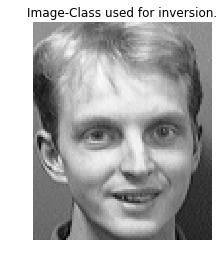

Predictions: [[9.3024498e-01 3.1423278e-05 7.6819568e-05 2.2709573e-05 1.5490159e-05
  3.3432112e-05 4.8825063e-05 5.7918303e-05 3.7219961e-05 4.2078758e-04
  1.1822559e-02 2.0577342e-04 2.9518694e-04 1.7622534e-04 7.3143891e-03
  1.4081156e-05 2.0998998e-03 4.7182006e-05 7.7630682e-03 6.3778623e-04
  5.7763908e-05 3.2837497e-04 1.1816827e-03 2.1480242e-04 1.0835322e-02
  6.3125837e-05 2.4183521e-04 1.6831889e-04 1.2359288e-02 8.8794430e-04
  6.0429550e-03 4.0970102e-04 2.8880509e-05 2.1104319e-05 1.1429513e-03
  1.6342546e-03 2.4684920e-04 2.1103132e-03 3.6603171e-05 6.2218361e-04]]
 Acc: 0.837393 and Loss: 0.161405 and Best Loss: 0.145997
Loop Escape.


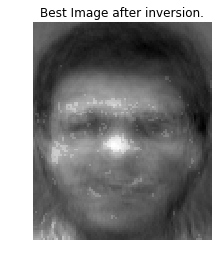

Predictions: [[8.5392541e-01 5.1909714e-04 1.0691341e-03 4.2596888e-03 8.6374236e-03
  6.5616062e-03 2.5942880e-03 6.3152911e-05 3.4383306e-04 4.8603886e-03
  3.8534236e-05 1.0887729e-02 1.5375722e-02 8.4093097e-04 1.5725139e-04
  9.6847173e-03 9.2377450e-04 1.7579472e-02 2.8621047e-04 8.1404607e-04
  3.9732619e-03 1.4065214e-03 1.5788455e-03 1.1391411e-04 5.4608600e-04
  5.1389914e-03 8.5015825e-05 7.0514991e-03 1.7866367e-03 1.7908135e-03
  4.7565285e-05 5.9388572e-04 6.2577822e-04 5.4428028e-04 2.4522378e-04
  1.3965250e-04 5.6273355e-03 6.8954495e-04 2.5792732e-03 2.6013417e-02]]


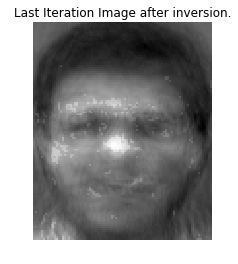

Predictions: [[8.3739346e-01 5.8059697e-04 1.0417971e-03 4.4210576e-03 9.5507642e-03
  8.2438765e-03 2.9042889e-03 7.2455914e-05 3.5219704e-04 5.4136300e-03
  3.3393142e-05 1.2589780e-02 1.8925196e-02 9.2866766e-04 1.7181180e-04
  1.0133780e-02 1.0064295e-03 1.7753111e-02 3.1283658e-04 8.4908103e-04
  4.6448689e-03 1.3812248e-03 1.6396093e-03 1.4240167e-04 5.1931432e-04
  5.9024333e-03 1.0588290e-04 8.1937360e-03 2.3467727e-03 2.0277109e-03
  5.4235050e-05 6.8686914e-04 6.0762477e-04 5.6349591e-04 2.8228384e-04
  1.6886203e-04 6.7199878e-03 7.3884026e-04 3.0748569e-03 2.7520692e-02]]


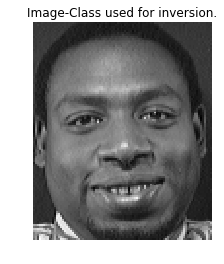

Predictions: [[4.4316053e-04 8.6856079e-01 2.2220770e-03 1.0904733e-03 3.9897119e-03
  1.9283347e-02 2.8430584e-03 1.9341056e-03 3.4809505e-04 1.4613305e-03
  5.6733228e-03 1.2992583e-03 1.4071637e-03 1.6677033e-03 4.1897278e-04
  2.9535682e-03 3.1896861e-04 7.6897396e-04 1.8960646e-03 1.8519667e-03
  2.7748017e-04 1.5972032e-03 8.5945328e-04 2.8647408e-02 1.2331699e-03
  1.4230938e-03 7.4695163e-05 3.4307293e-03 1.2621850e-04 7.9016632e-04
  1.4850998e-04 4.1720327e-03 8.8332797e-04 4.7528888e-03 1.5544186e-03
  6.3584780e-04 2.5141042e-02 1.0040613e-03 1.3435575e-03 1.4726921e-03]]
 Acc: 0.872724 and Loss: 0.127839 and Best Loss: 0.127839
Loop Escape.


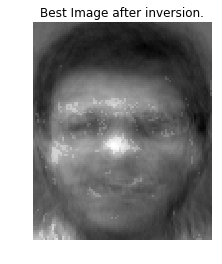

Predictions: [[9.5967735e-05 8.7272364e-01 4.2927061e-04 2.0379696e-02 2.5217992e-03
  2.6290698e-03 1.1370841e-03 6.1504812e-05 3.1025906e-04 4.0724119e-03
  4.0835443e-05 4.9727191e-03 6.9347005e-03 7.2931405e-04 6.2680425e-04
  1.2419895e-02 2.2653419e-04 6.5868311e-03 2.8070755e-04 9.7650028e-04
  4.4811959e-03 2.4489108e-03 3.1923433e-03 1.1926168e-04 1.5375396e-03
  5.2190442e-03 4.3419719e-04 6.4123934e-03 9.8719669e-04 2.3347109e-03
  3.1157051e-05 7.7893125e-04 1.2059871e-03 2.8678722e-04 2.8513567e-04
  2.3377543e-05 8.9427549e-03 1.5276287e-03 8.6361459e-03 1.2959754e-02]]


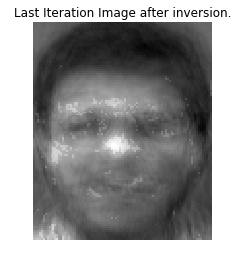

Predictions: [[9.5967735e-05 8.7272364e-01 4.2927061e-04 2.0379696e-02 2.5217992e-03
  2.6290698e-03 1.1370841e-03 6.1504812e-05 3.1025906e-04 4.0724119e-03
  4.0835443e-05 4.9727191e-03 6.9347005e-03 7.2931405e-04 6.2680425e-04
  1.2419895e-02 2.2653419e-04 6.5868311e-03 2.8070755e-04 9.7650028e-04
  4.4811959e-03 2.4489108e-03 3.1923433e-03 1.1926168e-04 1.5375396e-03
  5.2190442e-03 4.3419719e-04 6.4123934e-03 9.8719669e-04 2.3347109e-03
  3.1157051e-05 7.7893125e-04 1.2059871e-03 2.8678722e-04 2.8513567e-04
  2.3377543e-05 8.9427549e-03 1.5276287e-03 8.6361459e-03 1.2959754e-02]]


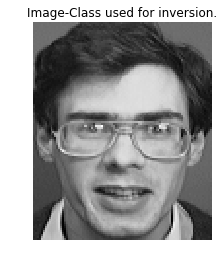

Predictions: [[5.2214722e-04 1.9741512e-04 8.0784768e-01 3.1774626e-03 2.2702636e-02
  7.6195785e-05 7.4624033e-05 2.8649615e-06 8.7586809e-03 1.6587998e-03
  8.3903823e-04 1.5992193e-06 2.6713067e-03 1.3157354e-04 5.1664584e-04
  2.7555168e-06 1.6469805e-02 2.0803493e-02 7.0866197e-04 2.7739033e-04
  2.3716623e-04 3.1284869e-02 3.5387578e-03 5.4712628e-04 4.8046091e-05
  1.5894398e-04 3.9841022e-02 4.5211160e-05 1.4956760e-04 3.2623112e-03
  8.4256826e-06 1.2454391e-03 3.6248370e-04 5.7589612e-03 2.5268673e-07
  4.0011881e-05 3.6576748e-05 8.4720263e-03 5.4533166e-06 1.7516501e-02]]
 Acc: 0.829108 and Loss: 0.171167 and Best Loss: 0.059775
Loop Escape.


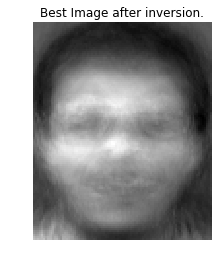

Predictions: [[6.48148183e-04 6.10393065e-04 3.12568963e-01 2.91138403e-02
  2.92969123e-03 2.18738765e-02 7.63558457e-03 5.70666930e-03
  1.47994189e-03 7.16975704e-03 1.18708514e-04 2.76869116e-03
  8.15498754e-02 4.30511049e-04 2.97187053e-05 1.50224217e-03
  1.38997380e-03 7.12352013e-03 6.70408364e-04 4.06133360e-04
  7.90063641e-04 2.90498976e-02 2.44915136e-04 9.47920853e-05
  1.07909727e-04 7.37233669e-04 4.78055299e-05 3.68487183e-03
  8.73474684e-03 1.14058526e-02 4.16099101e-06 5.94750419e-03
  4.82118485e-04 1.39150966e-03 8.80722655e-05 1.73511253e-05
  8.60117096e-03 4.07250552e-03 4.48501436e-04 4.38322365e-01]]


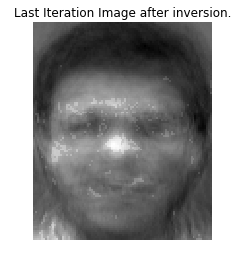

Predictions: [[1.5252882e-04 8.8231543e-05 8.2910776e-01 2.0282300e-02 1.9468542e-02
  4.9997112e-03 7.9147406e-03 4.3410761e-05 1.5123188e-04 2.3991896e-03
  1.0150925e-04 8.9150947e-03 1.3220843e-02 7.8000035e-04 2.6770457e-04
  3.9293701e-03 6.2177295e-04 1.7074225e-02 2.5189348e-04 1.1440355e-03
  3.1481085e-03 1.3685360e-03 1.8483140e-03 6.2207124e-05 4.1558919e-04
  8.4355772e-03 4.4949706e-05 4.3394249e-03 2.6669714e-03 5.8253789e-03
  1.4190096e-05 8.8368804e-04 4.0580416e-03 5.8198482e-04 5.3928100e-04
  4.0286428e-05 1.6701065e-02 1.0739416e-03 4.6581482e-03 1.2380051e-02]]


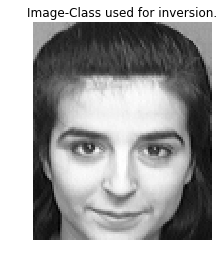

Predictions: [[2.55182804e-05 1.29870577e-05 1.02041149e-05 9.95142460e-01
  1.25665042e-06 1.39189751e-05 1.20084372e-03 1.10974216e-08
  1.63788733e-04 1.07985936e-04 2.01580228e-08 3.68873785e-08
  8.16475149e-05 9.25552467e-06 1.73270607e-08 2.48351029e-09
  3.94511808e-05 2.19729627e-04 1.78011447e-07 3.64211381e-08
  2.72475199e-06 1.42132980e-04 1.41524855e-04 1.04734099e-05
  2.91045154e-07 3.37903202e-06 9.42843399e-05 2.22853578e-06
  1.53277392e-06 8.43963699e-06 2.92426634e-08 5.25222231e-06
  4.35512129e-06 1.00199365e-07 5.92942362e-10 1.30549142e-06
  1.66624932e-06 1.07452877e-04 2.64372835e-09 2.44352384e-03]]
 Acc: 0.890976 and Loss: 0.109270 and Best Loss: 0.032080
Loop Escape.


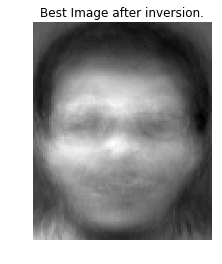

Predictions: [[2.2957014e-04 2.2849551e-04 1.7475882e-03 7.2104555e-01 1.1387481e-03
  7.7990303e-03 3.0896417e-03 2.1070931e-03 5.6319433e-04 2.9708983e-03
  4.2116772e-05 9.2286646e-04 3.0489437e-02 1.4879565e-04 1.1157386e-05
  6.6263374e-04 4.9070641e-04 2.8672908e-03 3.1727122e-04 1.5677899e-04
  2.7761929e-04 1.0792108e-02 1.0200121e-04 3.4828263e-05 4.1279436e-05
  2.5186085e-04 2.0242662e-05 1.4089316e-03 3.1367163e-03 4.8065344e-03
  1.8990985e-06 2.2203485e-03 1.7435037e-04 5.2997604e-04 3.3909684e-05
  7.2755324e-06 3.3295192e-03 1.6124289e-03 1.5240749e-04 1.9403681e-01]]


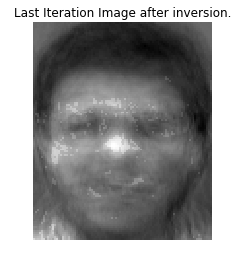

Predictions: [[4.95505919e-05 6.04579109e-04 1.48543797e-03 8.90976489e-01
  5.86618111e-03 2.45098327e-03 2.44950177e-03 2.96967628e-05
  2.39561108e-04 5.99285820e-04 5.38398308e-05 3.09948577e-03
  2.68116090e-02 3.10462608e-04 3.25882633e-04 3.73414136e-03
  4.77991271e-04 1.10805370e-02 7.31026055e-04 7.25255581e-04
  1.31819944e-03 1.56373088e-03 1.07526197e-03 6.21135696e-05
  5.65312454e-04 4.43912484e-03 1.27575491e-04 2.45468854e-03
  1.01800356e-03 2.97728903e-03 3.21047410e-05 2.00463482e-03
  1.96798518e-03 6.64848019e-04 1.19900615e-04 1.61366279e-05
  8.25240649e-03 1.36004225e-03 3.06969997e-03 1.48094920e-02]]


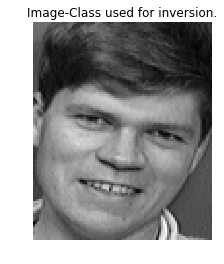

Predictions: [[2.12478462e-05 1.57484773e-03 2.06669699e-02 2.31577060e-03
  4.45870608e-01 1.76978286e-03 1.37817219e-03 5.24773532e-05
  7.57928239e-04 4.84865450e-04 1.04359956e-02 1.13010483e-05
  4.04579751e-03 2.37492452e-04 1.01010264e-04 5.18583074e-05
  5.62926801e-03 1.08997241e-01 1.37793231e-05 4.00440156e-04
  2.46382528e-03 4.07749583e-04 1.11973460e-03 2.33970210e-02
  5.62209461e-04 2.64300732e-03 2.98829824e-01 1.27241961e-04
  2.35838957e-06 7.20127500e-05 9.00827126e-06 1.38187301e-04
  1.28760701e-02 6.35197712e-03 1.09431767e-06 4.27146582e-03
  3.49243172e-02 1.95918401e-05 1.19357056e-03 5.77295525e-03]]
 Acc: 0.845297 and Loss: 0.154629 and Best Loss: 0.095932
Loop Escape.


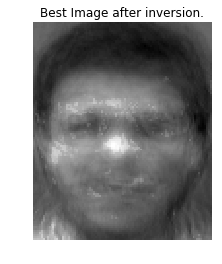

Predictions: [[1.04938437e-04 1.71170046e-04 1.58952922e-03 9.23291873e-03
  9.02779102e-01 2.44073337e-03 1.53679668e-03 4.61085583e-05
  1.81028474e-04 2.56401859e-03 4.66696038e-05 4.42839786e-03
  1.06040435e-02 4.33379580e-04 2.00983704e-04 1.53911486e-03
  2.27974058e-04 1.00129619e-02 3.41403240e-04 3.61329323e-04
  1.16132013e-03 7.29620282e-04 7.43116951e-04 6.75309275e-05
  5.49261109e-04 1.75499916e-03 8.54132595e-05 1.17460999e-03
  1.52666483e-03 3.37763340e-03 2.20399470e-05 8.68673669e-04
  2.18945160e-03 4.82955336e-04 1.60429918e-04 2.04679855e-05
  9.39619355e-03 9.42880055e-04 1.76555233e-03 2.41386443e-02]]


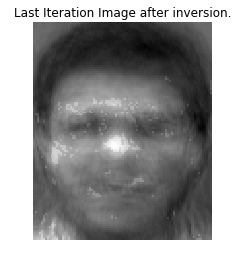

Predictions: [[3.9656159e-05 1.8577829e-04 1.2427139e-03 1.2319205e-02 8.4529734e-01
  2.5069288e-03 2.6760662e-03 3.2240812e-05 2.1538947e-04 1.6228561e-03
  4.5578712e-05 1.0220112e-02 1.6207891e-02 9.3044172e-04 3.7830340e-04
  2.0821597e-03 1.5282565e-04 3.5751004e-02 5.3465483e-04 4.7950566e-04
  1.7794895e-03 1.8272557e-03 8.3690183e-04 5.6125900e-05 5.8941066e-04
  2.8741804e-03 1.4457546e-04 3.2353764e-03 2.1615147e-03 5.4296493e-03
  1.7491102e-05 1.3235529e-03 1.7641584e-03 3.8628993e-04 1.8633100e-04
  2.8833088e-05 7.2753946e-03 1.8978965e-03 6.9724559e-03 2.8292550e-02]]


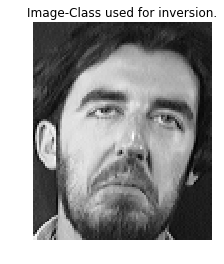

Predictions: [[5.5752912e-06 9.9445395e-02 3.4759231e-04 9.1988989e-04 6.9875615e-03
  1.4222209e-01 1.0028487e-02 1.7602967e-02 5.0082919e-03 7.1993083e-02
  8.0529123e-04 3.0472390e-02 5.0667919e-02 1.4325374e-02 1.5484109e-03
  1.1784464e-02 4.8470818e-03 7.4761664e-04 2.1659810e-02 1.1275070e-03
  7.6819316e-02 4.7852766e-02 2.7574638e-03 3.2380298e-02 1.1875905e-04
  1.9025322e-02 1.2095541e-05 2.4975291e-01 2.2262768e-04 2.4931978e-03
  5.5583241e-06 1.7333839e-02 3.7999761e-03 1.3175759e-03 2.3674176e-04
  1.8325495e-04 4.8910785e-03 8.3587049e-03 6.8039692e-04 3.9211407e-02]]
 Acc: 0.886204 and Loss: 0.114508 and Best Loss: 0.021102
Loop Escape.


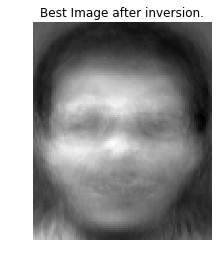

Predictions: [[5.86771290e-04 5.72708843e-04 4.70260764e-03 2.85560656e-02
  2.80510960e-03 1.95748024e-02 6.44989731e-03 5.25782583e-03
  1.37804437e-03 7.33170100e-03 1.01479156e-04 2.71101855e-03
  8.00656378e-02 3.54074116e-04 2.47087046e-05 1.41900452e-03
  1.44092320e-03 6.73209969e-03 7.13290647e-04 4.04623395e-04
  7.09528278e-04 2.64981277e-02 2.20317466e-04 8.95876728e-05
  9.49972309e-05 6.91970286e-04 4.86562967e-05 2.45298699e-01
  7.79923145e-03 1.22719584e-02 4.58720524e-06 4.59731137e-03
  4.17265139e-04 1.33877457e-03 8.19708657e-05 1.38134428e-05
  8.20538122e-03 3.96671845e-03 3.96216288e-04 5.16072512e-01]]


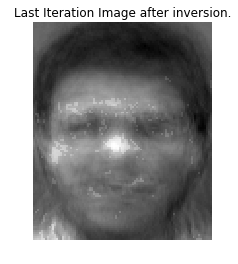

Predictions: [[1.3486604e-04 9.9762250e-04 9.9514006e-04 9.2747789e-03 7.9599516e-03
  8.1638608e-04 1.2490570e-03 3.8431102e-05 1.8868850e-04 7.7771167e-03
  5.3880016e-05 4.0908996e-03 1.1244498e-02 3.1483959e-04 2.2159760e-04
  3.9900108e-03 3.6541192e-04 1.1829567e-02 9.6235308e-04 6.9620775e-04
  1.9798991e-03 1.7892222e-03 1.2686910e-03 9.9114222e-05 3.4680343e-04
  1.6165794e-03 9.5287949e-05 8.8620412e-01 2.2252453e-03 2.2452641e-03
  3.4986278e-05 9.3180349e-04 3.0031935e-03 3.2050424e-04 7.1521979e-05
  5.2573792e-05 7.8525981e-03 1.0673520e-03 2.7974094e-03 2.2796461e-02]]


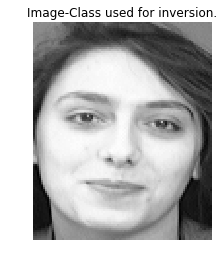

Predictions: [[4.45224359e-05 1.13352509e-02 3.13551282e-03 5.58621576e-03
  6.45161927e-05 4.16083355e-03 9.43732738e-01 2.61411862e-03
  4.43383295e-04 7.58961542e-05 1.09691708e-03 3.65653977e-05
  3.04740155e-03 2.34457268e-03 1.82847816e-05 8.25637471e-05
  1.20754754e-04 1.05387869e-03 1.89668208e-05 6.50856018e-05
  2.65267408e-06 2.22868146e-03 1.52358225e-05 2.10857554e-03
  1.98679409e-05 1.43494341e-04 9.54193820e-06 4.77416703e-04
  2.54869901e-05 4.88127407e-04 1.48289826e-06 1.43485451e-02
  4.92279883e-04 6.01767824e-05 1.28347244e-08 1.37077572e-04
  2.03134230e-04 2.97006227e-05 1.98536304e-06 1.28201558e-04]]
 Acc: 0.837215 and Loss: 0.163508 and Best Loss: 0.054958
Loop Escape.


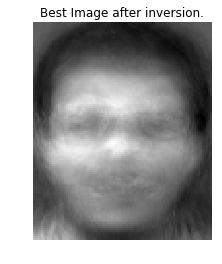

Predictions: [[5.72322460e-04 4.40051721e-04 3.81735899e-03 2.51240488e-02
  2.29323842e-03 1.63865350e-02 4.19963419e-01 4.63168928e-03
  1.13648747e-03 6.20079366e-03 1.13906666e-04 2.19423324e-03
  7.28636757e-02 3.00662301e-04 2.37196036e-05 1.11268030e-03
  9.89809050e-04 6.51147449e-03 6.54742878e-04 3.10352945e-04
  6.25823275e-04 2.22788583e-02 1.87663827e-04 8.31485449e-05
  7.62308482e-05 6.38448342e-04 4.23108650e-05 2.92627909e-03
  7.67124724e-03 1.05912564e-02 4.10540406e-06 4.71232366e-03
  3.55759665e-04 1.08594506e-03 6.90779416e-05 1.40221809e-05
  6.66960655e-03 3.07196984e-03 3.49277107e-04 3.72905493e-01]]


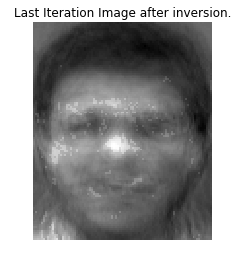

Predictions: [[9.56258227e-05 6.30020921e-04 6.18911814e-03 2.66032033e-02
  1.12329498e-02 2.06380873e-03 8.37215185e-01 6.62738967e-05
  7.11526591e-05 8.59947409e-04 3.77751639e-05 8.72969069e-03
  2.54753418e-02 7.22550612e-04 4.54529189e-04 2.18119915e-03
  1.79585579e-04 8.73753615e-03 7.11952569e-04 3.94585601e-04
  3.39774415e-03 1.67958881e-03 9.08815709e-04 1.21914723e-04
  2.08293117e-04 5.59823727e-03 1.39790573e-04 7.57629937e-03
  2.56952085e-03 3.38619412e-03 4.27736086e-05 1.34162873e-03
  2.45445664e-03 5.25460520e-04 2.53559789e-04 2.75537641e-05
  1.36700105e-02 6.95375260e-04 2.67829769e-03 2.00724453e-02]]


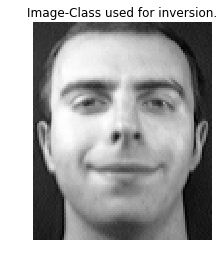

Predictions: [[1.18118995e-04 2.75338627e-03 4.17809588e-06 1.18891849e-05
  1.26679792e-04 1.14778494e-02 5.08609577e-04 4.37784553e-01
  1.66616028e-05 1.40890377e-04 3.56596633e-04 1.02038614e-01
  1.84604585e-06 2.68223975e-03 1.22505080e-04 2.88713723e-02
  2.49679288e-04 1.62480387e-06 2.97068693e-02 1.04416846e-04
  7.79628009e-02 5.93743345e-04 8.54979771e-06 2.35878974e-02
  7.80835035e-05 2.52316017e-02 3.84617124e-05 1.63612012e-02
  3.43465217e-04 2.46286538e-04 1.83436065e-03 1.00994956e-04
  9.64191090e-03 7.43225028e-05 4.75644087e-03 2.21256033e-01
  5.57021820e-04 1.40897291e-05 2.03825432e-04 3.03801389e-05]]
 Acc: 0.820870 and Loss: 0.179712 and Best Loss: 0.026030
Loop Escape.


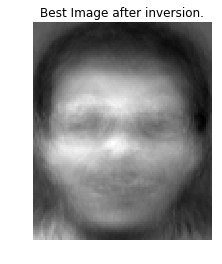

Predictions: [[5.0960114e-04 4.4010728e-04 3.7630517e-03 2.5269121e-02 2.1738326e-03
  1.8114248e-02 6.2772906e-03 3.1901798e-01 1.2468105e-03 5.3535802e-03
  9.8737284e-05 2.1387707e-03 6.8781435e-02 3.2971377e-04 2.5157038e-05
  1.2229808e-03 8.9553173e-04 6.7378264e-03 6.3349010e-04 3.1846896e-04
  5.9341179e-04 2.3338730e-02 1.9988141e-04 6.9809190e-05 8.1803948e-05
  6.0374074e-04 3.8456274e-05 2.9327758e-03 7.1616648e-03 9.4599323e-03
  3.7436773e-06 4.3443353e-03 3.9132437e-04 1.1431229e-03 7.1086128e-05
  1.3304108e-05 7.1139573e-03 3.4717012e-03 3.4182085e-04 4.7527760e-01]]


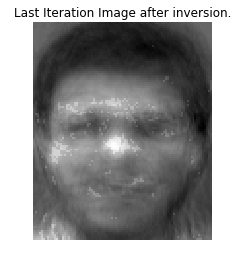

Predictions: [[1.8268294e-04 4.0559136e-04 4.4246349e-03 1.2655816e-02 6.9016642e-03
  1.0093960e-02 2.9903038e-03 8.2086998e-01 3.9042535e-04 2.9646247e-03
  1.4701877e-04 3.3820288e-03 2.6767850e-02 3.9087373e-04 2.2412365e-04
  3.3640533e-03 1.7646511e-04 1.2977203e-02 4.6214421e-04 3.1034264e-04
  5.6352825e-03 2.5862183e-03 1.9058813e-03 5.0527877e-05 2.5403199e-03
  6.1296839e-03 1.9483922e-04 5.2814274e-03 4.7074556e-03 1.9826179e-03
  4.6609010e-05 9.6188125e-04 1.3909002e-03 3.4867047e-04 5.0098629e-04
  5.4058062e-05 6.0541988e-03 1.1249167e-03 1.6158186e-02 3.2263722e-02]]


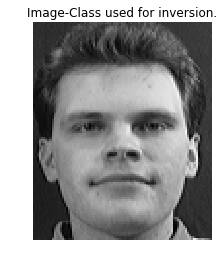

Predictions: [[2.2502494e-05 1.8928644e-05 2.5650666e-03 7.3831681e-05 4.9921298e-05
  7.2190742e-05 2.8898568e-05 1.0140184e-05 9.6895492e-01 2.0571545e-02
  3.0713019e-04 1.4796651e-06 1.5927960e-04 4.0347292e-04 2.8063316e-04
  1.2095342e-05 1.8734901e-05 2.5158073e-04 2.0453370e-04 1.0478268e-06
  7.7440796e-05 1.0985112e-03 1.2488767e-03 2.0375184e-04 1.5993190e-05
  3.5735069e-05 5.5687833e-05 1.3031880e-05 2.2706046e-04 3.0085302e-04
  2.7439098e-06 4.1099756e-05 2.3705473e-03 7.8994388e-05 5.1244774e-07
  1.8269023e-04 6.5062284e-07 1.1951805e-05 1.0067232e-05 1.5722102e-05]]
 Acc: 0.808641 and Loss: 0.190186 and Best Loss: 0.092278
Loop Escape.


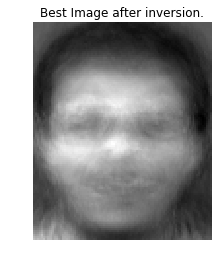

Predictions: [[6.19580736e-04 5.70126518e-04 5.05158538e-03 2.98735630e-02
  2.98770959e-03 1.96079072e-02 7.77367037e-03 6.02422655e-03
  1.43363029e-01 8.51533283e-03 1.34618138e-04 2.93089449e-03
  9.99642313e-02 3.81026155e-04 3.18171660e-05 1.50087767e-03
  1.26016478e-03 9.00097378e-03 8.29583383e-04 4.22549580e-04
  7.35579175e-04 3.32969427e-02 2.76379345e-04 9.89504260e-05
  1.08460634e-04 7.74027780e-04 5.86245151e-05 3.84186534e-03
  8.85888655e-03 1.28694912e-02 5.48707658e-06 6.05209405e-03
  4.94783802e-04 1.51905254e-03 8.51488585e-05 1.78531081e-05
  9.84263886e-03 4.29698545e-03 4.76750516e-04 5.75446486e-01]]


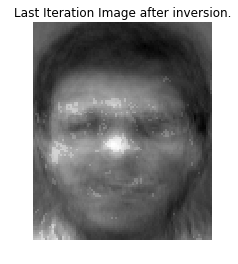

Predictions: [[1.56436159e-04 5.39439206e-04 1.90346839e-03 2.71864757e-02
  1.71268731e-02 7.31555326e-03 1.15747924e-03 6.92945687e-05
  8.08641315e-01 3.77372676e-03 8.88309223e-05 1.02144117e-02
  1.83561575e-02 1.43519673e-03 4.51659405e-04 5.42238913e-03
  1.95470813e-04 1.80460662e-02 4.95471410e-04 2.19019456e-03
  4.10751812e-03 4.41645691e-03 1.35797297e-03 1.05239924e-04
  8.58397107e-04 7.37110153e-03 1.87596335e-04 4.44739545e-03
  3.14106909e-03 3.96875618e-03 6.85554842e-05 1.51976291e-03
  9.55117983e-04 5.19407564e-04 4.45730169e-04 5.70728298e-05
  1.17150191e-02 1.95913226e-03 5.14153671e-03 2.28912178e-02]]


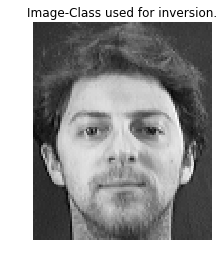

Predictions: [[2.8113814e-04 9.9874742e-05 1.4410177e-04 3.6892882e-03 4.1763368e-04
  1.9005213e-03 1.2782383e-03 5.5816581e-06 2.3121752e-02 6.8186200e-01
  1.1457342e-05 2.8674976e-06 7.1120556e-03 2.8937762e-03 2.2119607e-04
  5.3454052e-05 2.0548272e-01 2.6015770e-05 7.6080105e-05 1.3324660e-05
  8.9621154e-04 2.7692616e-03 2.2866931e-03 1.9146611e-03 1.2594763e-05
  1.4974377e-03 9.1082242e-04 8.3076739e-06 5.1106518e-04 6.4517168e-04
  2.1582141e-06 4.5107063e-05 1.0744216e-03 5.4315871e-05 2.9181372e-06
  1.4731041e-04 1.4589902e-04 5.9140177e-04 2.0956425e-06 5.7789046e-02]]
 Acc: 0.840406 and Loss: 0.159600 and Best Loss: 0.069686
Loop Escape.


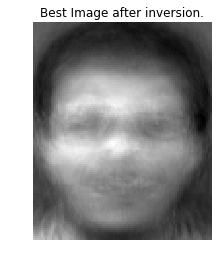

Predictions: [[5.45760733e-04 4.46849561e-04 3.68008949e-03 2.31272727e-02
  2.03671283e-03 1.52266892e-02 6.30002934e-03 4.00070613e-03
  1.27651601e-03 4.48644280e-01 1.05249215e-04 1.78420823e-03
  5.79048246e-02 2.99873995e-04 2.23412080e-05 1.17672770e-03
  1.01495709e-03 6.04798179e-03 5.89738484e-04 3.04200948e-04
  5.58446627e-04 2.03918889e-02 2.19366993e-04 7.69857434e-05
  7.94751541e-05 5.98397164e-04 3.80654092e-05 3.00191483e-03
  6.76050177e-03 9.59279109e-03 4.05582114e-06 3.95381963e-03
  3.42237676e-04 1.08629139e-03 6.78040742e-05 1.30217713e-05
  6.52282219e-03 3.36901401e-03 3.61177808e-04 3.68426889e-01]]


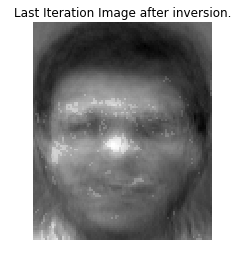

Predictions: [[1.2188215e-04 4.4142414e-04 8.2002213e-04 7.9855127e-03 6.0496912e-03
  4.3948307e-03 6.7992433e-04 2.4536404e-05 3.1542874e-04 8.4040606e-01
  4.3035594e-05 3.6571342e-03 2.7251964e-02 6.2461477e-04 1.6820345e-04
  2.8684242e-03 6.5045111e-04 3.5259258e-02 2.7917014e-04 5.3583726e-04
  3.2122806e-03 2.5554637e-03 2.0821246e-03 7.0113485e-05 6.4627407e-04
  2.4103113e-03 7.7466582e-05 1.0429842e-02 4.1928170e-03 1.2678496e-03
  3.1399424e-05 9.4544643e-04 6.5158482e-04 5.1768776e-04 2.3770990e-04
  2.1438784e-05 1.0522491e-02 2.0150344e-03 5.5499286e-03 1.9985098e-02]]


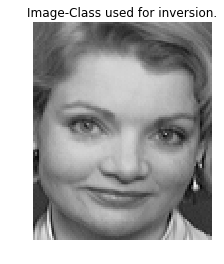

Predictions: [[1.09641033e-03 9.65261657e-04 2.84266222e-04 4.77350877e-05
  5.66592265e-04 1.37730647e-04 6.24518580e-05 2.49319146e-05
  9.77287273e-05 1.18890039e-05 9.74901617e-01 3.87942164e-05
  5.69134609e-05 9.36792130e-05 4.51045089e-05 1.34519269e-05
  2.94886631e-05 1.18931383e-03 1.76603417e-03 2.72287009e-03
  2.44438911e-06 7.31002539e-04 3.89265991e-03 2.97104102e-03
  4.06867475e-04 7.55645488e-06 1.61106233e-04 1.02619946e-04
  3.37026059e-03 3.10006290e-04 4.02752521e-05 1.00766472e-03
  1.10141656e-04 1.07006647e-03 8.27547137e-06 1.38269379e-05
  3.69325950e-04 6.03694527e-04 6.12760021e-04 5.57959975e-05]]
 Acc: 0.703607 and Loss: 0.295189 and Best Loss: 0.218232
Loop Escape.


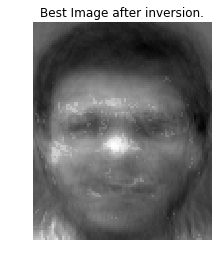

Predictions: [[3.2788253e-04 4.9072423e-04 5.3620925e-03 1.8947018e-02 1.3266510e-02
  9.9251904e-03 3.6493377e-03 9.8364530e-05 3.6699764e-04 9.6236179e-03
  7.8111047e-01 9.6340356e-03 2.1566533e-02 5.1933446e-04 6.2718894e-04
  7.7679143e-03 8.3958858e-04 2.4568619e-02 1.4003196e-03 1.5750253e-03
  1.4413692e-03 3.5855821e-03 2.1333313e-03 9.8758836e-05 1.5642266e-03
  3.7131200e-03 1.7356237e-04 5.6288536e-03 4.0509696e-03 5.7869325e-03
  6.5161410e-05 3.1829437e-03 1.0172858e-02 9.6180028e-04 6.8915822e-04
  1.1185603e-04 2.0608468e-02 1.2852617e-03 4.4608186e-03 1.8617989e-02]]


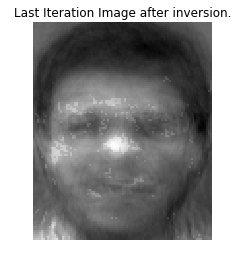

Predictions: [[2.19843903e-04 5.07015444e-04 7.90129602e-03 3.69635969e-02
  2.30448972e-02 1.29197789e-02 2.99830735e-03 9.18443184e-05
  3.92362504e-04 1.50619186e-02 7.03606844e-01 1.00217881e-02
  2.98037566e-02 5.37784013e-04 1.32372160e-03 9.97183193e-03
  1.76666293e-03 2.67673079e-02 2.92709400e-03 2.19495292e-03
  2.26769620e-03 5.60532184e-03 2.14946386e-03 1.13694376e-04
  2.02126708e-03 4.33158269e-03 3.41765757e-04 7.15710083e-03
  4.54354612e-03 3.49598844e-03 1.19182499e-04 5.05941687e-03
  1.11165987e-02 1.69790443e-03 7.13760906e-04 1.15551782e-04
  3.20502631e-02 1.73197885e-03 9.34754498e-03 1.69976112e-02]]


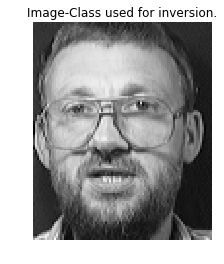

Predictions: [[1.7421131e-05 2.7219378e-03 4.2262977e-07 6.2639947e-07 3.3681570e-06
  2.2736115e-02 1.8929991e-04 5.5600391e-03 1.7798325e-07 3.1521761e-06
  2.4560787e-04 9.5013309e-01 3.6306261e-05 3.8655280e-04 1.3480943e-05
  5.5509633e-03 1.0140469e-06 4.8934240e-08 7.9021407e-03 1.3999020e-05
  1.2463972e-05 1.8057501e-05 1.0327193e-05 3.7432159e-04 2.4365598e-05
  1.7766182e-04 1.9886913e-08 4.0614695e-04 8.9035610e-05 8.3455481e-05
  5.3452421e-04 1.9403925e-04 4.6783462e-06 5.0711998e-05 7.2447764e-04
  1.4758279e-04 1.5613141e-03 5.2200185e-06 6.4786334e-05 9.9040733e-07]]
 Acc: 0.889797 and Loss: 0.109368 and Best Loss: 0.090544
Loop Escape.


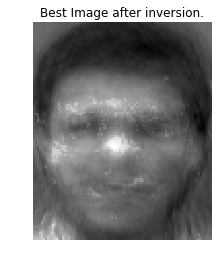

Predictions: [[1.57287810e-04 2.31188416e-04 1.47098186e-03 7.86092319e-03
  1.31713562e-02 2.77706143e-03 9.81442281e-04 2.86921659e-05
  1.65184145e-04 1.04049419e-03 5.29047902e-05 9.09249246e-01
  8.20280425e-03 3.43677937e-04 2.85866437e-04 1.43694773e-03
  4.57132497e-04 1.33429123e-02 3.50324874e-04 5.46572788e-04
  1.90457713e-03 9.01336549e-04 6.75806194e-04 6.77542703e-05
  6.77244563e-04 1.96556910e-03 4.42728779e-05 2.65301345e-03
  1.26832863e-03 1.58742233e-03 3.26967456e-05 1.84234581e-03
  1.36270036e-03 3.75501055e-04 1.01993675e-04 2.98604082e-05
  8.26259982e-03 1.12790661e-03 2.09503085e-03 1.08713238e-02]]


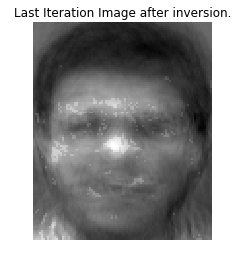

Predictions: [[2.1896663e-04 2.6126095e-04 1.7550722e-03 6.1922795e-03 1.8113418e-02
  1.3454675e-03 1.4357073e-03 8.9903269e-06 1.9414729e-04 1.1554813e-03
  7.3636540e-05 8.8979733e-01 5.9087989e-03 1.0067638e-03 4.4378944e-04
  1.9329423e-03 6.4296613e-04 2.3627700e-02 2.6662584e-04 9.0928120e-04
  2.5439397e-03 1.3882712e-03 7.4872759e-04 4.6422632e-05 1.1870923e-03
  2.4268145e-03 5.2262258e-05 4.2752712e-03 2.1154128e-03 1.2759664e-03
  3.7632719e-05 1.3072700e-03 1.0782115e-03 3.3909926e-04 5.8348203e-05
  2.2291651e-05 7.6626358e-03 1.2689789e-03 3.6985381e-03 1.3176274e-02]]


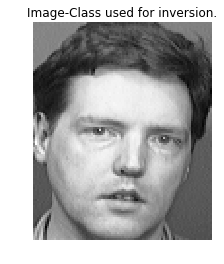

Predictions: [[2.03190511e-03 4.23445395e-04 1.02634053e-03 9.91807319e-03
  7.09953345e-03 4.39073017e-04 3.96754331e-04 3.38169315e-07
  7.79655311e-05 2.37395149e-03 3.71677947e-04 1.15382227e-05
  7.80744731e-01 6.20773790e-05 1.20238201e-05 6.10717507e-06
  2.97506456e-03 1.21036191e-02 1.21993162e-05 1.29385167e-04
  1.96303517e-04 1.07218768e-03 1.27575658e-02 4.79855342e-03
  6.31752191e-05 6.39248719e-06 4.92848270e-03 1.16220166e-04
  2.02023166e-05 3.53887258e-03 6.39061591e-06 6.99380587e-04
  1.47741652e-04 2.87312374e-04 1.67827309e-07 1.01822707e-05
  3.60555388e-03 5.10979723e-03 2.22584663e-06 1.42417535e-01]]
 Acc: 0.919511 and Loss: 0.081041 and Best Loss: 0.011762
Loop Escape.


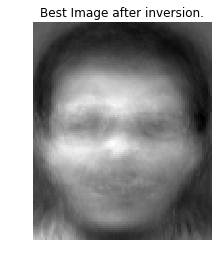

Predictions: [[1.1897993e-04 1.2110822e-04 9.0648665e-04 5.5739363e-03 5.0865253e-04
  3.7328447e-03 1.4918568e-03 1.0432081e-03 3.0154933e-04 1.1329895e-03
  2.4571847e-05 5.3412322e-04 8.7465739e-01 7.3594689e-05 5.9929394e-06
  2.9835312e-04 2.4393013e-04 1.9007194e-03 1.6544599e-04 7.7845580e-05
  1.3945375e-04 5.8321664e-03 5.9173639e-05 1.8670238e-05 2.1862241e-05
  1.4205527e-04 1.1300069e-05 6.9248519e-04 1.7212252e-03 2.8310493e-03
  1.0966736e-06 1.1221888e-03 8.9645269e-05 2.9174599e-04 1.8374667e-05
  3.4582974e-06 1.6379202e-03 7.2467496e-04 8.6620683e-05 9.1641366e-02]]


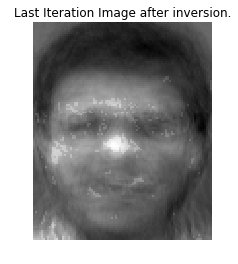

Predictions: [[6.8188863e-05 1.1819252e-04 8.8876241e-04 1.2781841e-02 4.8352359e-03
  1.1034076e-03 1.9401640e-03 2.4341303e-05 9.8204786e-05 1.0141839e-03
  4.5526616e-05 3.2505423e-03 9.1951132e-01 3.7483010e-04 7.8527344e-05
  2.6700457e-03 3.4740218e-04 1.0422896e-02 3.5636561e-04 2.0840434e-04
  6.1495823e-04 1.4149307e-03 5.6202029e-04 4.6425877e-05 2.5363424e-04
  2.1026747e-03 1.2287838e-04 1.7911219e-03 2.3392378e-03 3.7406699e-03
  2.1796401e-05 6.8498717e-04 1.3051067e-03 2.4080135e-04 1.6009987e-04
  3.0367029e-05 6.6749644e-03 6.9463608e-04 2.0545372e-03 1.5005821e-02]]


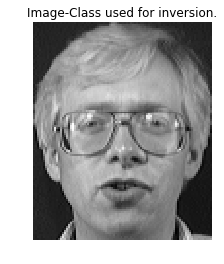

Predictions: [[1.24634407e-05 9.05170309e-05 1.19908259e-06 1.16783203e-05
  4.02026171e-06 2.61043297e-05 2.52210739e-04 4.86920268e-04
  3.32934142e-05 1.98072739e-04 4.79096605e-04 4.71691834e-04
  1.93179244e-06 9.89893138e-01 7.47383674e-05 2.35604704e-04
  3.25187357e-05 2.86643262e-06 6.31129005e-05 8.46509374e-06
  6.67805143e-04 6.94438233e-04 7.09566575e-06 6.07186172e-04
  9.89652326e-05 2.31450176e-04 1.92090653e-07 1.77694659e-03
  1.38546340e-04 1.59072151e-04 2.95364618e-04 1.59446154e-05
  2.48641532e-04 2.57514112e-05 1.35202892e-04 2.40370887e-03
  2.99625594e-06 1.93414098e-06 1.06337444e-04 2.80150334e-06]]
 Acc: 0.852417 and Loss: 0.147861 and Best Loss: 0.146273
Loop Escape.


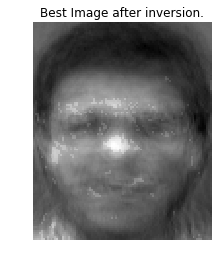

Predictions: [[2.6139242e-04 7.3819625e-04 1.5395518e-03 8.2450015e-03 1.4455202e-02
  1.8256138e-03 1.7212827e-03 2.9762676e-05 2.9170999e-04 5.1482115e-03
  1.8644554e-05 3.9584124e-03 1.1501097e-02 8.5362512e-01 1.9799225e-04
  3.7785305e-03 2.9761897e-04 1.5973955e-02 2.1374100e-04 1.0528961e-03
  2.5988352e-03 6.9548032e-04 1.0546091e-03 7.7011144e-05 3.1404174e-04
  5.7696290e-03 1.1638609e-04 6.2817843e-03 8.1485631e-03 4.8612258e-03
  2.2871602e-05 1.2067561e-03 1.6155705e-03 4.8312425e-04 2.4723081e-04
  3.3044780e-05 7.6576057e-03 9.9414343e-04 7.7393083e-03 2.5208678e-02]]


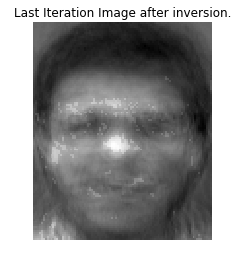

Predictions: [[3.3962412e-04 7.6464500e-04 1.2360632e-03 7.2955280e-03 1.6101982e-02
  1.9209353e-03 1.5772345e-03 2.5100127e-05 2.0238104e-04 4.5123994e-03
  1.7707889e-05 4.8325965e-03 8.5503981e-03 8.5241652e-01 1.7368444e-04
  3.6318575e-03 3.3455255e-04 1.7930975e-02 1.5470208e-04 9.9168986e-04
  2.8069154e-03 5.5439741e-04 8.7854249e-04 8.5532272e-05 2.7601860e-04
  6.3257315e-03 1.1129614e-04 6.3189035e-03 8.5447161e-03 5.0332900e-03
  1.9221110e-05 9.9351211e-04 1.6994306e-03 4.7341228e-04 1.7683530e-04
  3.1441414e-05 7.9908175e-03 8.2610681e-04 6.5890308e-03 2.7254645e-02]]


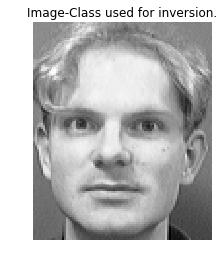

Predictions: [[1.4205702e-02 3.9123840e-04 1.9793973e-05 3.0959941e-06 2.3162762e-05
  6.6069474e-06 1.4473654e-05 1.4559718e-04 3.0385656e-04 4.2400134e-05
  4.4313595e-03 3.2617692e-05 4.9352242e-05 5.9391012e-05 9.3193573e-01
  1.5439926e-05 5.1425037e-04 4.4913213e-06 1.1555763e-03 1.5435613e-03
  2.7229513e-05 1.7091939e-05 3.9486989e-05 1.6377012e-03 2.0760408e-02
  1.6407629e-03 8.1248982e-05 1.0137988e-04 1.8342590e-03 1.2342745e-03
  1.5568699e-02 2.6421528e-04 2.9260627e-05 1.5549446e-04 1.7632318e-04
  1.3412464e-03 2.8692597e-05 1.6245938e-05 9.2948940e-05 5.5461656e-05]]
 Acc: 0.809651 and Loss: 0.190279 and Best Loss: 0.170153
Loop Escape.


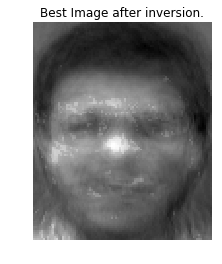

Predictions: [[1.9510055e-04 4.3022589e-04 2.9770611e-03 1.0484564e-02 1.4728130e-02
  5.6809732e-03 2.9887843e-03 7.7536693e-05 2.6310873e-04 5.4116072e-03
  8.7564214e-05 1.3535303e-02 1.7994581e-02 8.4002828e-04 8.2982928e-01
  2.8837887e-03 6.1930495e-04 1.7409343e-02 6.4303138e-04 1.0331435e-03
  4.2936699e-03 1.7307615e-03 6.1338476e-04 1.9949746e-04 1.1797542e-03
  7.5805201e-03 1.6798169e-04 1.9181441e-03 1.6136065e-03 4.1246046e-03
  2.5474135e-05 1.2186466e-03 1.6936800e-03 5.7255727e-04 4.0565827e-04
  2.1827826e-05 1.3536252e-02 1.7934587e-03 4.3110754e-03 2.4886806e-02]]


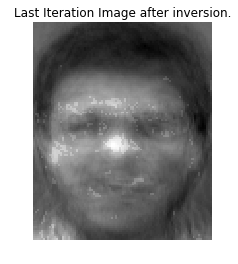

Predictions: [[1.0098484e-04 5.8271043e-04 2.4397688e-03 1.5986657e-02 1.8164581e-02
  2.6586598e-03 2.5455034e-03 2.3881488e-05 1.5140319e-04 3.1731352e-03
  7.5338277e-05 4.4647887e-02 1.0395602e-02 3.7070565e-04 8.0965054e-01
  3.7203648e-03 2.8797015e-04 1.4719373e-02 7.5988169e-04 6.5259915e-04
  5.0605447e-03 2.2839811e-03 3.6291379e-04 1.3201238e-04 9.5228880e-04
  1.0648696e-02 2.0602577e-04 3.0086942e-03 1.3751769e-03 2.0870587e-03
  9.1597358e-06 1.1487727e-03 1.1569703e-03 4.1573742e-04 3.5408541e-04
  4.1655814e-05 1.0556208e-02 1.7813431e-03 1.0536857e-02 1.6774157e-02]]


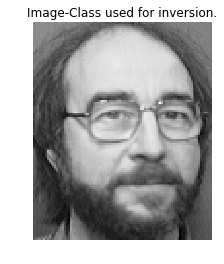

Predictions: [[6.6463095e-03 3.9039305e-04 2.1767037e-05 5.7819460e-07 8.9227217e-07
  3.3765089e-05 5.6403933e-06 2.2180281e-04 1.5559568e-05 2.4459336e-04
  3.3287643e-03 1.6011022e-02 1.6902311e-06 4.9254909e-04 1.3409307e-02
  6.8462461e-02 2.5567602e-04 2.2044859e-09 1.4725906e-02 2.2059039e-03
  3.1999204e-02 5.0198188e-04 9.9701490e-03 7.5308740e-04 1.2575378e-04
  1.3215281e-04 1.5251278e-06 1.7670228e-04 8.4156673e-03 1.1557096e-02
  8.8074788e-02 5.7898782e-04 8.1218095e-06 2.0285877e-05 7.1913379e-01
  1.5155282e-03 5.8404745e-05 2.9395685e-05 4.5177378e-04 2.1119820e-05]]
 Acc: 0.753167 and Loss: 0.247988 and Best Loss: 0.205159
Loop Escape.


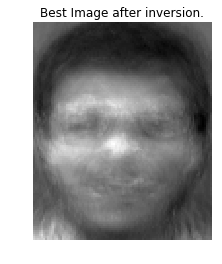

Predictions: [[8.31719255e-04 7.98206020e-04 5.91059355e-03 2.35408712e-02
  1.82473715e-02 1.15839969e-02 6.60297181e-03 1.16754789e-03
  3.73805116e-04 6.27423450e-03 3.08596645e-04 3.45134432e-03
  5.36388978e-02 5.85880247e-04 1.35959461e-04 2.36499845e-03
  1.34716346e-03 2.37706657e-02 1.53935072e-03 7.83420459e-04
  4.25007707e-03 6.77260431e-03 1.24566769e-03 1.87660378e-04
  1.20795355e-03 1.95064384e-03 3.01493157e-04 1.45654497e-03
  4.78603784e-03 2.46560797e-02 1.51674813e-05 3.22517613e-03
  2.19147652e-03 3.70799960e-03 6.36404514e-01 4.08421365e-05
  2.19385307e-02 1.59796735e-03 1.36234821e-03 1.19443685e-01]]


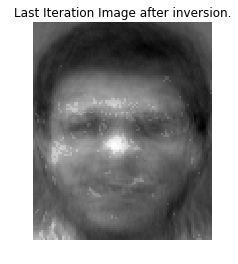

Predictions: [[2.5226877e-04 8.5369259e-04 4.3233074e-03 2.5694491e-02 2.0652710e-02
  4.6926551e-03 4.1978150e-03 4.2933178e-05 3.9870545e-04 4.4083162e-03
  4.7701711e-04 7.1875546e-03 3.8608737e-02 1.4923314e-03 4.0153490e-04
  1.1699343e-02 1.2604235e-03 1.9709058e-02 8.0359844e-04 6.6389376e-04
  3.6440096e-03 3.2635280e-03 1.2523506e-02 1.3085808e-04 1.4091290e-03
  7.2732437e-03 5.7739415e-04 2.6666755e-03 4.5884112e-03 1.1353513e-02
  1.8950152e-05 2.8911699e-03 2.8228429e-03 8.6187135e-04 7.5316745e-01
  6.6793204e-05 3.0744640e-02 2.2336522e-03 2.4408326e-03 9.5011638e-03]]


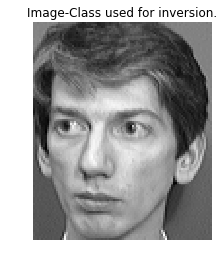

Predictions: [[1.6406249e-02 1.4531248e-03 2.1289365e-02 2.0473670e-02 1.2316155e-03
  5.2504600e-03 1.8287548e-03 4.8635629e-05 7.1643788e-04 1.3542682e-03
  1.4128288e-03 2.1156254e-06 1.0770758e-02 2.1427748e-04 3.8235937e-04
  6.8184931e-04 6.2490857e-01 9.1120005e-03 1.0951119e-04 5.1443228e-03
  3.6129629e-04 2.0417799e-03 4.5552747e-03 4.8402607e-02 3.5737630e-03
  4.0653703e-04 2.2857195e-02 3.7154488e-05 5.0113969e-05 1.2988059e-02
  3.2593912e-04 3.1186689e-03 7.6254238e-03 9.2245062e-04 1.2127633e-04
  1.1931070e-03 6.9023296e-03 1.7402424e-02 2.4128733e-04 1.4408214e-01]]
 Acc: 0.790446 and Loss: 0.209367 and Best Loss: 0.193614
Loop Escape.


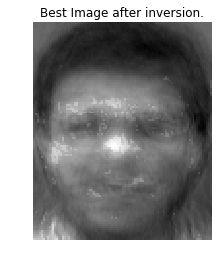

Predictions: [[3.2117928e-04 6.0174009e-04 1.7676286e-03 1.8711746e-02 9.8078139e-03
  5.9573581e-03 2.6205964e-03 6.3199965e-05 3.4093662e-04 4.4652647e-03
  8.2740567e-05 1.5843706e-02 2.0605149e-02 7.4394577e-04 2.9015506e-04
  2.3293612e-03 8.0638039e-01 2.7125141e-02 5.5195217e-04 5.0686725e-04
  3.6085269e-03 2.8346837e-03 1.6971444e-03 1.1252341e-04 2.2379286e-03
  5.4279882e-03 1.9356274e-04 4.9448721e-03 1.1454998e-03 2.8578020e-03
  5.4756907e-05 2.3181590e-03 3.7981002e-03 6.4225501e-04 2.9722179e-04
  7.2404895e-05 1.8781919e-02 3.0159976e-03 6.3708411e-03 2.0470956e-02]]


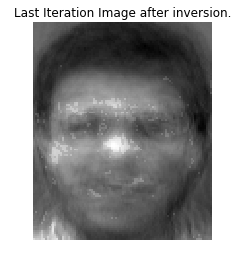

Predictions: [[5.9037516e-04 8.5110962e-04 1.0077177e-03 1.3026224e-02 1.1690281e-02
  5.4170913e-03 2.6101230e-03 3.1084561e-05 4.2299984e-04 4.1088359e-03
  1.2265245e-04 3.1247051e-02 2.9327990e-02 8.0464908e-04 2.6598395e-04
  3.1943454e-03 7.9044604e-01 2.4961347e-02 7.8309514e-04 5.6507194e-04
  6.2031518e-03 3.9868611e-03 2.2833464e-03 1.0775036e-04 3.8931316e-03
  3.7728073e-03 2.4068497e-04 5.4904572e-03 1.1447903e-03 2.1446147e-03
  6.2563180e-05 2.7903377e-03 4.8158900e-03 7.8457705e-04 2.5106262e-04
  7.1713657e-05 1.8641898e-02 5.1048659e-03 6.8646227e-03 9.8708039e-03]]


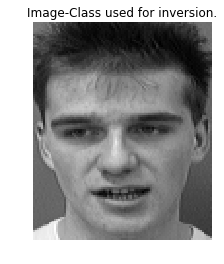

Predictions: [[2.5567742e-06 3.1049320e-04 7.0303888e-04 1.8091298e-04 1.2453144e-02
  1.3807548e-05 2.9349074e-05 6.4658911e-06 6.2263018e-05 3.7650416e-06
  5.7070461e-05 3.8062069e-07 5.2265002e-04 1.6449872e-05 1.9518739e-06
  2.9510511e-07 9.8151108e-04 9.7330248e-01 9.2797236e-06 1.0034612e-03
  4.0905870e-06 5.2082371e-05 3.8197561e-04 4.4592444e-04 1.2426345e-03
  1.4538117e-05 9.2817376e-05 5.9402722e-05 9.8668033e-06 1.4564178e-05
  3.5619254e-07 1.7640086e-04 3.3331983e-04 5.0483961e-03 1.0874972e-07
  4.5220545e-06 1.4176330e-03 5.1631127e-04 3.5857494e-05 4.8782610e-04]]
 Acc: 0.871980 and Loss: 0.128018 and Best Loss: 0.092221
Loop Escape.


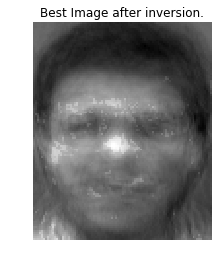

Predictions: [[8.9079498e-05 2.0855620e-04 1.1107326e-03 7.3389425e-03 8.8127842e-03
  3.1482086e-03 9.9728350e-04 3.1383130e-05 2.0535025e-04 2.8172939e-03
  4.3477023e-05 5.3840908e-03 1.3875507e-02 4.8429836e-04 1.5634445e-04
  1.8295705e-03 3.5810392e-04 9.0756607e-01 2.9654565e-04 4.1934979e-04
  1.7565569e-03 1.0135721e-03 8.0946845e-04 1.1129056e-04 5.3909526e-04
  1.8133990e-03 1.0714054e-04 2.2783994e-03 9.4358664e-04 2.7057771e-03
  2.0185074e-05 8.3914562e-04 1.4066688e-03 2.7788445e-04 1.2991395e-04
  1.8616583e-05 6.8223453e-03 7.3429919e-04 3.4097123e-03 1.9089989e-02]]


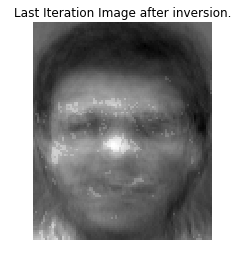

Predictions: [[1.0329679e-04 4.0164514e-04 1.6086258e-03 6.7594755e-03 7.8373235e-03
  4.3465546e-03 1.4275691e-03 3.5486406e-05 1.3413916e-04 3.0234985e-03
  3.7119349e-05 8.1308372e-03 3.3656251e-02 9.2253060e-04 2.0332927e-04
  2.3444025e-03 5.0909846e-04 8.7198007e-01 3.6227112e-04 1.0135216e-03
  2.2278270e-03 1.1760150e-03 1.1668275e-03 8.4998966e-05 6.4316561e-04
  3.2792673e-03 1.8007826e-04 3.5551107e-03 1.7652469e-03 1.9070522e-03
  1.7674374e-05 7.9269015e-04 2.5960591e-03 2.6925196e-04 1.4843988e-04
  3.2870023e-05 7.0194909e-03 8.7841263e-04 1.1347976e-02 1.6074607e-02]]


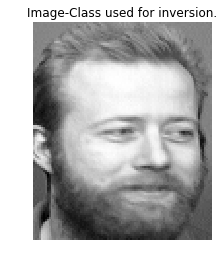

Predictions: [[9.7692767e-03 1.0412922e-03 7.0087750e-05 3.2805810e-06 1.9218021e-05
  4.3266333e-05 3.2893811e-06 2.2998263e-05 2.3853412e-05 1.0974841e-03
  7.7943788e-03 7.5521000e-04 7.2348237e-05 2.2260506e-04 1.5458508e-03
  3.3253240e-03 2.8014256e-04 6.6349176e-06 8.5935664e-01 1.3422492e-03
  1.2609553e-04 1.8892057e-02 1.2612182e-02 4.7546178e-03 2.9403477e-03
  7.7702245e-04 4.3688426e-05 1.3945860e-04 1.0701313e-03 3.8539354e-02
  2.1049157e-03 2.1699630e-03 1.2903638e-05 1.8602958e-03 8.9184335e-03
  7.6650060e-05 3.3273795e-05 1.5337097e-02 9.6465147e-04 1.8316373e-03]]
 Acc: 0.794145 and Loss: 0.204228 and Best Loss: 0.187208
Loop Escape.


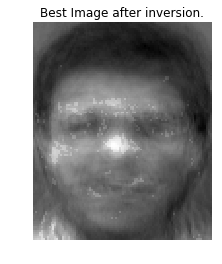

Predictions: [[7.6858298e-05 6.4723985e-04 1.1236080e-03 2.5361679e-02 9.5342593e-03
  7.6190867e-03 6.2152566e-03 5.9386952e-05 3.5968554e-04 1.7461416e-03
  1.4628212e-04 5.8592288e-03 2.3893993e-02 6.4628472e-04 6.5701839e-04
  1.2725131e-03 5.0585438e-04 1.5112328e-02 8.1220520e-01 5.8157166e-04
  2.6635814e-03 3.3786851e-03 1.3651779e-03 1.7991380e-04 9.7983761e-04
  2.8510375e-03 2.2173062e-04 7.0376690e-03 4.1791336e-03 3.1145725e-03
  7.3252719e-05 2.1425413e-03 2.1581596e-03 8.2262832e-04 3.5848716e-04
  4.4738281e-05 1.0364443e-02 8.8690087e-04 6.9547086e-03 3.6599137e-02]]


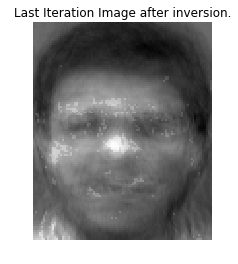

Predictions: [[6.6150467e-05 7.3540595e-04 1.1939254e-03 2.2135817e-02 1.3815808e-02
  6.4229132e-03 8.9228228e-03 8.1882645e-05 5.4037187e-04 2.1545591e-03
  1.6411950e-04 7.0698420e-03 2.8934248e-02 7.1108696e-04 9.1256580e-04
  1.4411546e-03 6.7233795e-04 1.7124081e-02 7.9414499e-01 8.1730477e-04
  2.1287755e-03 3.6577939e-03 1.3270057e-03 2.2529018e-04 1.0459161e-03
  2.9594637e-03 2.5501565e-04 1.0548430e-02 4.6839206e-03 3.0010329e-03
  9.1108224e-05 2.9443365e-03 2.7188896e-03 1.0267746e-03 3.2529986e-04
  4.3035903e-05 1.0388696e-02 8.9144747e-04 1.0184855e-02 3.3491597e-02]]


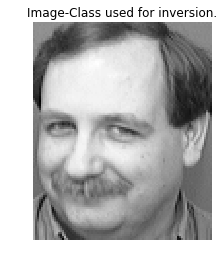

Predictions: [[1.0843003e-02 1.4648102e-02 1.3690614e-04 5.7999292e-05 6.5677821e-05
  5.6690059e-04 1.0440047e-03 3.3628117e-04 4.6588273e-05 2.1816251e-05
  4.2882906e-03 8.8091763e-03 1.8803710e-04 8.0470880e-04 4.9610343e-04
  3.1431227e-03 4.3579647e-03 2.8555712e-04 4.6882215e-03 8.8013971e-01
  1.9974110e-04 1.9562463e-04 1.6228937e-03 2.8582918e-03 8.2662227e-03
  5.3010968e-04 4.7812828e-06 9.5633965e-05 7.5638993e-03 1.6452605e-02
  3.3484048e-03 9.1897035e-03 1.8204335e-04 2.0409278e-03 1.7233638e-03
  2.2978291e-03 3.3631902e-03 2.4258480e-03 6.9788139e-04 1.9727866e-03]]
 Acc: 0.819751 and Loss: 0.179289 and Best Loss: 0.148842
Loop Escape.


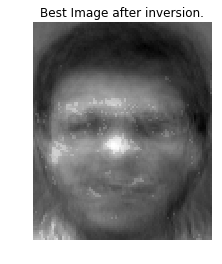

Predictions: [[1.6139235e-04 4.9773592e-04 2.0554001e-03 1.2865064e-02 1.3298602e-02
  7.5294655e-03 1.5477900e-03 2.9239585e-05 1.0294701e-03 3.5957026e-03
  1.0043056e-04 7.9587707e-03 1.7233854e-02 8.3130255e-04 8.2717487e-04
  2.6693917e-03 3.1378775e-04 1.5353512e-02 5.2296312e-04 8.5083258e-01
  2.1769288e-03 1.9075000e-03 2.6381994e-03 5.6981815e-05 7.7998446e-04
  6.2084431e-03 1.1965054e-04 4.6845218e-03 2.4578506e-03 2.7932865e-03
  2.4776935e-05 1.3297340e-03 3.0969179e-03 6.2412862e-04 2.5790205e-04
  5.5114542e-05 7.0934701e-03 1.6972770e-03 3.8340737e-03 1.8909616e-02]]


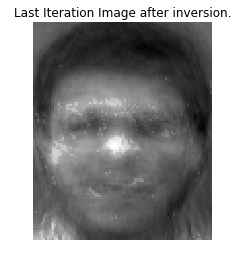

Predictions: [[1.4127755e-04 1.0525539e-03 1.3574362e-03 1.3356019e-02 1.7953811e-02
  8.3985478e-03 1.6342885e-03 2.8993785e-05 1.3573909e-03 5.0524585e-03
  8.6898071e-05 1.0052983e-02 2.4024742e-02 8.8641187e-04 1.2466089e-03
  2.4218077e-03 3.7679402e-04 1.7988546e-02 6.6685228e-04 8.1975055e-01
  1.8888392e-03 2.1852290e-03 2.4186424e-03 4.8538695e-05 1.3018071e-03
  1.1058946e-02 2.0165773e-04 6.6093346e-03 3.5426731e-03 2.7450346e-03
  2.7543359e-05 1.1466161e-03 2.5034104e-03 5.5633386e-04 3.1385160e-04
  5.3424141e-05 6.8896469e-03 2.0363252e-03 4.2133783e-03 2.2423517e-02]]


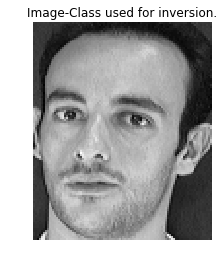

Predictions: [[5.2197435e-04 2.4207925e-02 2.7368860e-03 1.4298674e-04 4.1454858e-03
  1.0342289e-03 1.2878334e-03 4.6305925e-02 2.8766072e-04 1.6657611e-04
  1.2000012e-03 1.8857328e-03 5.0137448e-04 3.4583525e-03 3.1743877e-04
  4.8833463e-04 4.7187536e-04 1.9122139e-03 1.3110242e-04 2.7721768e-02
  7.0509478e-02 3.2852073e-03 5.4049542e-05 3.2125507e-03 8.1668387e-04
  2.8486576e-04 9.5318528e-06 5.6502301e-01 3.5099004e-04 1.3385463e-02
  1.2859820e-02 1.1997723e-03 1.3421305e-01 4.4151259e-04 6.5527501e-04
  3.8980208e-02 3.4378123e-02 2.3467954e-04 8.4834429e-04 3.3173390e-04]]
 Acc: 0.886204 and Loss: 0.114508 and Best Loss: 0.021102
Loop Escape.


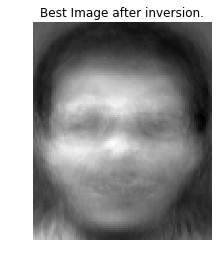

Predictions: [[5.86771290e-04 5.72708843e-04 4.70260764e-03 2.85560656e-02
  2.80510960e-03 1.95748024e-02 6.44989731e-03 5.25782583e-03
  1.37804437e-03 7.33170100e-03 1.01479156e-04 2.71101855e-03
  8.00656378e-02 3.54074116e-04 2.47087046e-05 1.41900452e-03
  1.44092320e-03 6.73209969e-03 7.13290647e-04 4.04623395e-04
  7.09528278e-04 2.64981277e-02 2.20317466e-04 8.95876728e-05
  9.49972309e-05 6.91970286e-04 4.86562967e-05 2.45298699e-01
  7.79923145e-03 1.22719584e-02 4.58720524e-06 4.59731137e-03
  4.17265139e-04 1.33877457e-03 8.19708657e-05 1.38134428e-05
  8.20538122e-03 3.96671845e-03 3.96216288e-04 5.16072512e-01]]


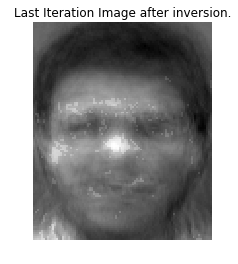

Predictions: [[1.3486604e-04 9.9762250e-04 9.9514006e-04 9.2747789e-03 7.9599516e-03
  8.1638608e-04 1.2490570e-03 3.8431102e-05 1.8868850e-04 7.7771167e-03
  5.3880016e-05 4.0908996e-03 1.1244498e-02 3.1483959e-04 2.2159760e-04
  3.9900108e-03 3.6541192e-04 1.1829567e-02 9.6235308e-04 6.9620775e-04
  1.9798991e-03 1.7892222e-03 1.2686910e-03 9.9114222e-05 3.4680343e-04
  1.6165794e-03 9.5287949e-05 8.8620412e-01 2.2252453e-03 2.2452641e-03
  3.4986278e-05 9.3180349e-04 3.0031935e-03 3.2050424e-04 7.1521979e-05
  5.2573792e-05 7.8525981e-03 1.0673520e-03 2.7974094e-03 2.2796461e-02]]


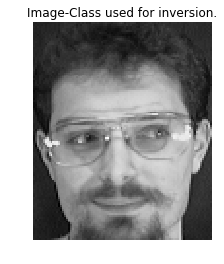

Predictions: [[5.87055320e-06 4.16320654e-06 5.02142466e-05 7.36039947e-04
  2.10444032e-05 2.88817428e-05 4.29300644e-06 6.36451159e-06
  5.76466043e-03 1.57460407e-03 5.01859722e-06 4.63914461e-07
  7.95106553e-06 1.00299134e-04 1.70563976e-06 1.66436257e-06
  1.71331674e-04 4.90371895e-04 1.98334783e-05 1.29719938e-05
  6.19969142e-05 9.85785544e-01 4.45404621e-05 2.25308668e-05
  4.56640919e-06 3.49717156e-05 6.29986927e-04 2.50640369e-06
  5.31936930e-05 1.63527056e-05 1.57564486e-07 5.98602855e-05
  2.17976002e-03 6.91988796e-04 8.61138449e-09 1.09094755e-04
  1.17319496e-06 1.23495178e-04 6.41727695e-07 1.16989971e-03]]

 Above Probability Criteria!: 0.993549644947

Loop Escape.


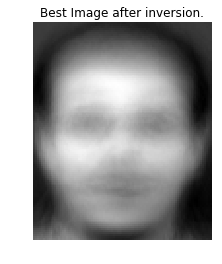

Predictions: [[3.5962334e-05 1.4347181e-05 2.3058502e-04 3.6795691e-04 1.1833823e-05
  7.3262403e-04 2.1771659e-04 4.2271565e-04 1.4975147e-04 1.5688852e-04
  2.4559861e-06 8.0166363e-05 1.2973754e-03 1.1345842e-05 2.0243740e-06
  1.2899877e-05 4.0524719e-05 5.6055782e-05 1.7070210e-05 8.2494835e-06
  6.5373711e-06 9.9354964e-01 1.9994006e-06 4.1859325e-06 3.4899691e-07
  1.3206393e-05 6.8072904e-07 4.7263503e-04 1.8186549e-04 8.5718370e-05
  2.9311710e-07 1.5416510e-04 7.3255796e-06 1.0870361e-05 9.8772796e-07
  1.2540504e-06 8.0850914e-05 2.7685537e-04 7.8671483e-06 1.2739660e-03]]


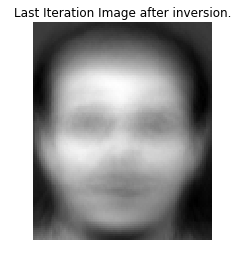

Predictions: [[3.5962334e-05 1.4347181e-05 2.3058502e-04 3.6795691e-04 1.1833823e-05
  7.3262403e-04 2.1771659e-04 4.2271565e-04 1.4975147e-04 1.5688852e-04
  2.4559861e-06 8.0166363e-05 1.2973754e-03 1.1345842e-05 2.0243740e-06
  1.2899877e-05 4.0524719e-05 5.6055782e-05 1.7070210e-05 8.2494835e-06
  6.5373711e-06 9.9354964e-01 1.9994006e-06 4.1859325e-06 3.4899691e-07
  1.3206393e-05 6.8072904e-07 4.7263503e-04 1.8186549e-04 8.5718370e-05
  2.9311710e-07 1.5416510e-04 7.3255796e-06 1.0870361e-05 9.8772796e-07
  1.2540504e-06 8.0850914e-05 2.7685537e-04 7.8671483e-06 1.2739660e-03]]


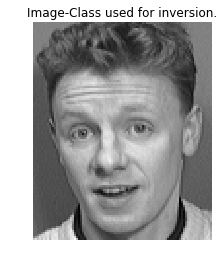

Predictions: [[1.3666422e-03 4.5056501e-03 1.2425880e-02 3.9500868e-04 7.4822782e-03
  3.2455333e-05 1.1870802e-03 3.4707680e-06 1.3223811e-03 2.3861260e-03
  6.5549952e-03 3.5515775e-06 1.5181972e-03 1.8627837e-04 6.8091642e-04
  6.1908337e-05 4.0793989e-02 3.2501903e-03 1.3446563e-04 7.8330818e-04
  1.8082651e-04 1.7007308e-03 8.2566464e-01 6.5090130e-03 8.9226086e-03
  9.3003205e-04 1.3198210e-02 2.0368356e-05 1.0796707e-04 4.7167882e-04
  1.1972015e-04 3.1747583e-02 1.6857352e-03 6.4567397e-03 3.7576261e-04
  2.0657004e-04 3.5438554e-03 8.6795568e-04 6.6539139e-04 1.1549892e-02]]
 Acc: 0.875060 and Loss: 0.125174 and Best Loss: 0.125174
Loop Escape.


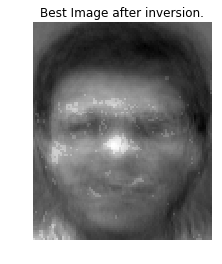

Predictions: [[7.8832738e-05 6.8306405e-04 2.8822250e-03 8.1819845e-03 1.1926302e-02
  9.3923016e-03 1.5705065e-03 3.0311594e-05 2.0864935e-04 5.6864875e-03
  6.4894237e-05 3.7241254e-03 1.1880775e-02 3.3981871e-04 1.4620948e-04
  3.1035622e-03 6.2072632e-04 1.4411085e-02 3.9860958e-04 7.9133996e-04
  3.5504368e-03 2.5398715e-03 8.7505984e-01 1.2802187e-04 7.2648440e-04
  2.4573228e-03 2.9551017e-04 2.2875024e-03 7.2234205e-04 3.8432945e-03
  2.8962830e-05 1.9002578e-03 1.4634271e-03 6.0438458e-04 5.6507479e-04
  2.3698565e-05 8.3363848e-03 9.5293747e-04 4.4372017e-03 1.3955292e-02]]


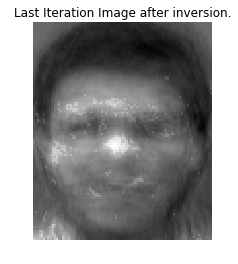

Predictions: [[7.8832738e-05 6.8306405e-04 2.8822250e-03 8.1819845e-03 1.1926302e-02
  9.3923016e-03 1.5705065e-03 3.0311594e-05 2.0864935e-04 5.6864875e-03
  6.4894237e-05 3.7241254e-03 1.1880775e-02 3.3981871e-04 1.4620948e-04
  3.1035622e-03 6.2072632e-04 1.4411085e-02 3.9860958e-04 7.9133996e-04
  3.5504368e-03 2.5398715e-03 8.7505984e-01 1.2802187e-04 7.2648440e-04
  2.4573228e-03 2.9551017e-04 2.2875024e-03 7.2234205e-04 3.8432945e-03
  2.8962830e-05 1.9002578e-03 1.4634271e-03 6.0438458e-04 5.6507479e-04
  2.3698565e-05 8.3363848e-03 9.5293747e-04 4.4372017e-03 1.3955292e-02]]


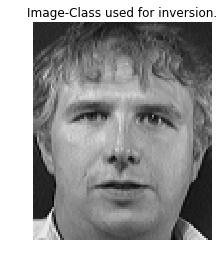

Predictions: [[3.31772535e-05 9.37414356e-03 1.78027444e-03 4.78189148e-04
  3.56889167e-03 1.79272797e-03 9.03009262e-04 9.91830253e-04
  3.36763496e-03 2.62989383e-03 4.28476371e-03 2.40562251e-04
  9.74352879e-05 5.01772761e-03 1.39162038e-03 1.94261680e-04
  2.36974121e-03 1.01360457e-03 2.91860453e-03 2.29437326e-04
  2.86001858e-04 4.59163357e-03 2.63185444e-04 8.91957581e-01
  1.67368562e-04 7.32012559e-03 2.89814088e-05 8.45427567e-04
  8.24057315e-06 4.81271782e-05 5.42443740e-06 3.28082446e-04
  2.27817129e-02 1.79570839e-02 1.04850296e-04 2.15252442e-03
  6.18944922e-03 5.40358087e-05 2.19956390e-03 3.28581846e-05]]
 Acc: 0.756427 and Loss: 0.244154 and Best Loss: 0.213094
Loop Escape.


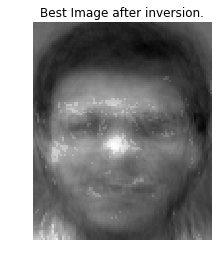

Predictions: [[3.9961419e-04 4.8341035e-04 1.6944857e-03 9.0233739e-03 1.0506276e-02
  7.1864086e-03 3.3585841e-03 4.6724581e-05 4.1268228e-04 3.9250436e-03
  5.3909116e-05 1.4372914e-02 1.4636350e-02 1.0037399e-03 9.8619051e-04
  1.9962161e-03 5.8556057e-04 3.1823713e-02 7.9052680e-04 7.0757186e-04
  6.3547795e-03 2.6087784e-03 2.6528684e-03 7.8670293e-01 2.0934414e-04
  1.0313389e-02 3.2959340e-04 8.6431000e-03 2.4259449e-03 3.9346381e-03
  7.4445459e-05 4.1766395e-03 1.1948631e-03 9.0998190e-04 5.4009072e-04
  2.0299436e-05 1.2091202e-02 1.5337043e-03 6.8424735e-03 4.4447731e-02]]


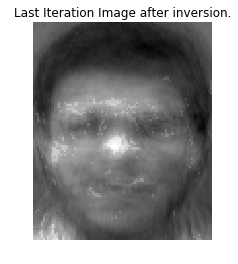

Predictions: [[5.3361879e-04 5.0561270e-04 1.6797266e-03 9.2864493e-03 1.4124955e-02
  4.9772998e-03 3.8381075e-03 3.6978487e-05 4.3397339e-04 4.7982791e-03
  4.9937604e-05 1.5703673e-02 1.7212953e-02 1.1417211e-03 8.0918515e-04
  2.0380002e-03 6.9686666e-04 3.8474400e-02 7.5587881e-04 7.2901958e-04
  6.9236578e-03 2.3147236e-03 2.2577394e-03 7.5642729e-01 1.5062343e-04
  9.3076220e-03 3.2336661e-04 7.7554714e-03 3.0618012e-03 5.0949496e-03
  9.4546282e-05 6.0979752e-03 1.3992330e-03 1.0133188e-03 4.8804554e-04
  1.8385774e-05 1.5753305e-02 1.7941415e-03 7.9244133e-03 5.3972833e-02]]


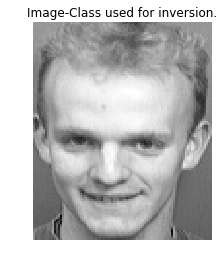

Predictions: [[4.4505902e-02 4.5532049e-03 7.7002471e-05 3.7145857e-03 1.0599399e-03
  3.1949512e-05 5.5333285e-04 6.7527004e-04 6.3930876e-03 4.1248798e-04
  2.0137502e-02 2.5167508e-04 6.6453249e-05 2.9047504e-03 5.3169220e-03
  2.8705847e-04 2.1093348e-02 2.3286121e-03 1.3120426e-02 9.0057431e-03
  8.7174140e-03 1.4594878e-02 1.6228497e-02 4.7632102e-02 5.8991224e-01
  4.4525787e-03 3.3738021e-02 8.6249417e-04 4.7420920e-03 9.4100591e-03
  2.8503673e-02 2.3209299e-03 7.7535100e-03 2.0875834e-02 4.9612620e-03
  4.6569910e-02 7.3950435e-04 1.3825281e-02 1.8986076e-03 5.7717748e-03]]
 Acc: 0.877195 and Loss: 0.122210 and Best Loss: 0.118162
Loop Escape.


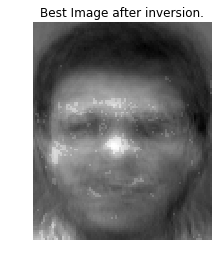

Predictions: [[5.4953049e-05 6.7661965e-04 1.0554342e-03 1.1688253e-02 1.0749408e-02
  1.1796270e-03 8.3862146e-04 7.2396004e-05 3.1561186e-04 1.9542058e-03
  6.4358966e-05 7.9454081e-03 1.5089229e-02 2.2780403e-04 1.5392955e-04
  3.8443455e-03 9.9974871e-04 1.4582101e-02 3.2273281e-04 9.6165569e-04
  2.5628321e-03 1.3296654e-03 1.4234929e-03 1.7469614e-05 8.8182729e-01
  1.7926977e-03 1.7244028e-04 2.8423602e-03 2.3357072e-03 2.8318218e-03
  6.2169027e-05 9.7698683e-04 2.9801759e-03 3.2038335e-04 1.5526310e-04
  8.1352548e-05 5.2745948e-03 2.1496252e-03 1.9509944e-03 1.6136358e-02]]


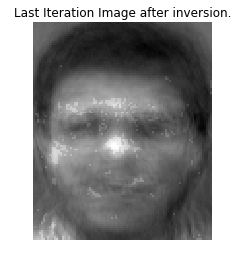

Predictions: [[5.5033841e-05 7.1258453e-04 1.1540385e-03 1.1510044e-02 1.0879350e-02
  1.0931033e-03 8.0409821e-04 7.4032898e-05 3.2041146e-04 2.0471902e-03
  7.0678398e-05 8.6582201e-03 1.7487042e-02 2.3989815e-04 1.4541569e-04
  3.7946922e-03 9.8612905e-04 1.6793508e-02 3.3286729e-04 1.0322004e-03
  2.4661117e-03 1.3619260e-03 1.4511009e-03 1.6598640e-05 8.7719518e-01
  1.7241612e-03 1.7772241e-04 2.9764592e-03 2.3301428e-03 2.9211785e-03
  6.7118730e-05 9.7034581e-04 3.2385078e-03 2.9926133e-04 1.5713202e-04
  8.1173406e-05 5.1997402e-03 2.0100395e-03 1.9307350e-03 1.5234726e-02]]


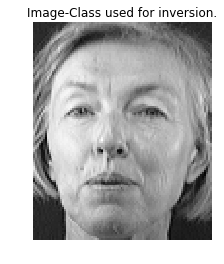

Predictions: [[5.4178323e-04 3.5579652e-03 2.6924967e-05 3.0102915e-04 9.6220385e-05
  9.6693020e-03 8.4094638e-03 3.8549583e-02 6.9468128e-03 7.2919228e-03
  1.2673220e-03 1.5869371e-03 3.3916990e-06 8.6093105e-02 2.8443744e-02
  4.5505962e-03 4.3673723e-04 4.7995054e-05 1.8366182e-02 4.8022065e-03
  2.7024138e-03 1.0212327e-03 2.8383294e-05 2.1869427e-02 5.4924265e-03
  6.4149314e-01 7.6999801e-04 1.0749634e-02 1.0415589e-03 3.5096338e-04
  8.9491351e-04 5.5562705e-04 6.8893707e-03 4.7955752e-04 4.5251218e-03
  7.3178485e-02 2.6943898e-04 5.4247289e-06 6.6750548e-03 1.8647392e-05]]
 Acc: 0.848928 and Loss: 0.151417 and Best Loss: 0.122342
Loop Escape.


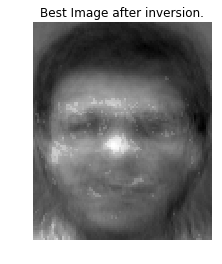

Predictions: [[1.1261974e-04 2.5898672e-04 2.2789040e-03 1.5644725e-02 8.5037332e-03
  6.6412832e-03 2.2534207e-03 7.3095158e-05 3.4695209e-04 3.0932559e-03
  6.0093480e-05 5.1247403e-03 1.1393341e-02 5.4800807e-04 3.8578681e-04
  2.5898747e-03 4.6569644e-04 1.2039225e-02 4.3520739e-04 8.1078324e-04
  3.5930716e-03 1.6986239e-03 8.8787469e-04 1.2377248e-04 3.5559468e-04
  8.7719977e-01 1.5058534e-04 3.0477864e-03 2.3100381e-03 3.6836967e-03
  2.7779457e-05 1.9545746e-03 2.1651343e-03 4.4332896e-04 2.5387722e-04
  3.2974578e-05 1.0677927e-02 6.7032117e-04 2.9892772e-03 1.4674243e-02]]


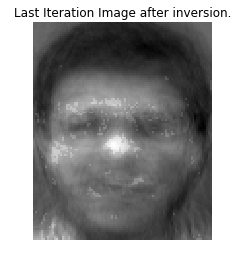

Predictions: [[8.3143423e-05 2.3052903e-04 1.4877879e-03 2.3957007e-02 1.4018463e-02
  1.1269911e-02 2.7027428e-03 6.6194851e-05 5.8052072e-04 2.7430137e-03
  1.1806879e-04 1.5550371e-02 1.1803987e-02 7.9785800e-04 4.9896404e-04
  2.5824690e-03 5.8516697e-04 9.2519037e-03 8.7925105e-04 1.4480543e-03
  2.6964855e-03 1.8976976e-03 1.3679753e-03 7.3892537e-05 3.6523008e-04
  8.4892839e-01 1.9683660e-04 4.8829559e-03 2.6030301e-03 3.2283647e-03
  2.7940807e-05 3.0829974e-03 2.4100936e-03 3.0713514e-04 2.7228522e-04
  3.6460002e-05 1.2000546e-02 1.0112168e-03 4.1070483e-03 9.8480508e-03]]


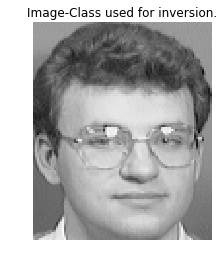

Predictions: [[1.30996807e-04 3.50148803e-05 4.80926712e-04 1.72357832e-04
  7.09772250e-03 2.12581241e-07 3.04083414e-07 1.37782266e-08
  4.56548623e-05 1.20097815e-04 1.59379852e-04 3.61686325e-09
  3.32153945e-06 3.27519814e-07 2.21761111e-05 3.25884528e-08
  2.81368336e-03 3.34813987e-04 2.40125655e-06 1.47681703e-06
  1.08001177e-05 4.53178509e-05 3.66593944e-03 1.55031774e-03
  2.44454597e-04 3.40423830e-05 9.74134922e-01 4.93780394e-09
  8.54231601e-08 4.68189910e-07 3.53677888e-06 9.62558943e-07
  2.81678931e-05 4.01817408e-04 2.08660396e-08 9.86202358e-05
  3.24831170e-04 4.57652823e-05 5.50371215e-06 7.98370875e-03]]
 Acc: 0.790952 and Loss: 0.208639 and Best Loss: 0.170975
Loop Escape.


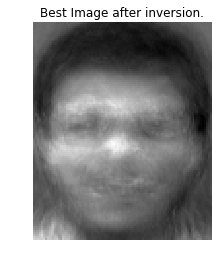

Predictions: [[1.0119620e-03 1.2592576e-03 6.1701420e-03 2.1941913e-02 1.3468606e-02
  1.0551515e-02 5.4638162e-03 1.0195780e-03 4.1176018e-04 5.2488786e-03
  3.3635731e-04 3.6808271e-03 4.8537236e-02 7.1979407e-04 1.2610998e-04
  2.0921987e-03 1.4543965e-03 2.3747206e-02 2.0771499e-03 6.9272669e-04
  3.3863802e-03 5.5541927e-03 1.1978466e-03 2.0020717e-04 1.1813401e-03
  2.4639294e-03 6.8053955e-01 1.2192922e-03 6.8822573e-03 1.7412700e-02
  1.8286242e-05 3.2888094e-03 2.6021241e-03 3.5310504e-03 3.6579027e-04
  4.6606663e-05 2.4789447e-02 1.5638501e-03 1.2947790e-03 9.2450179e-02]]


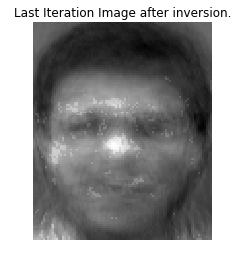

Predictions: [[7.4892785e-05 1.8787723e-03 7.5778307e-04 7.1879490e-03 7.8549832e-03
  7.5330599e-03 3.6364500e-03 2.1753128e-04 8.1444456e-04 1.9143027e-03
  6.7659217e-05 2.4532641e-03 2.3773860e-02 8.3399640e-04 5.6586083e-04
  4.0636864e-03 1.5664799e-03 3.3014402e-02 6.4170634e-04 9.4835786e-04
  6.5414100e-03 2.7841800e-03 5.4711225e-03 5.6840020e-04 9.8325452e-04
  1.1998277e-02 7.9095161e-01 3.3749726e-03 2.5829955e-03 7.5145448e-03
  3.3246342e-05 5.3233909e-03 2.9449586e-03 1.0365553e-03 1.6001089e-03
  7.1586037e-05 2.9257488e-02 1.4056715e-03 9.1969557e-03 1.6559964e-02]]


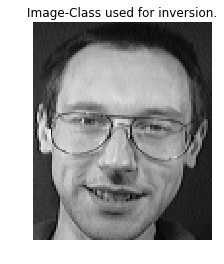

Predictions: [[2.48785932e-06 5.72924619e-04 6.04011002e-05 2.96195958e-05
  3.12480756e-06 3.71520431e-03 2.83866003e-03 9.48129018e-05
  4.41222546e-05 1.04070195e-05 6.78062361e-06 1.63849199e-03
  6.75272022e-04 2.27205758e-03 4.32584739e-06 2.06487257e-05
  5.67545430e-06 9.07031936e-04 1.45107537e-04 1.17466226e-03
  5.71799872e-04 1.62244972e-03 1.52519378e-05 2.57478823e-04
  8.08588629e-06 8.95421836e-05 1.21681282e-07 9.79240596e-01
  2.22796007e-04 1.06578856e-03 1.81863675e-06 2.13549286e-03
  3.32102645e-04 2.76274095e-05 4.78351603e-06 1.77120219e-05
  1.77716138e-05 1.37171650e-04 3.15125362e-06 6.38426809e-06]]
 Acc: 0.886204 and Loss: 0.114508 and Best Loss: 0.021102
Loop Escape.


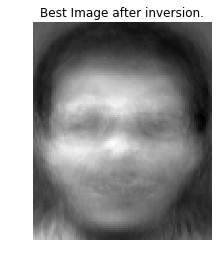

Predictions: [[5.86771290e-04 5.72708843e-04 4.70260764e-03 2.85560656e-02
  2.80510960e-03 1.95748024e-02 6.44989731e-03 5.25782583e-03
  1.37804437e-03 7.33170100e-03 1.01479156e-04 2.71101855e-03
  8.00656378e-02 3.54074116e-04 2.47087046e-05 1.41900452e-03
  1.44092320e-03 6.73209969e-03 7.13290647e-04 4.04623395e-04
  7.09528278e-04 2.64981277e-02 2.20317466e-04 8.95876728e-05
  9.49972309e-05 6.91970286e-04 4.86562967e-05 2.45298699e-01
  7.79923145e-03 1.22719584e-02 4.58720524e-06 4.59731137e-03
  4.17265139e-04 1.33877457e-03 8.19708657e-05 1.38134428e-05
  8.20538122e-03 3.96671845e-03 3.96216288e-04 5.16072512e-01]]


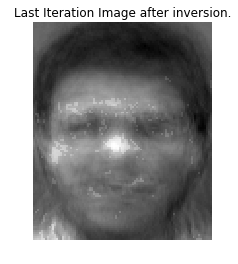

Predictions: [[1.3486604e-04 9.9762250e-04 9.9514006e-04 9.2747789e-03 7.9599516e-03
  8.1638608e-04 1.2490570e-03 3.8431102e-05 1.8868850e-04 7.7771167e-03
  5.3880016e-05 4.0908996e-03 1.1244498e-02 3.1483959e-04 2.2159760e-04
  3.9900108e-03 3.6541192e-04 1.1829567e-02 9.6235308e-04 6.9620775e-04
  1.9798991e-03 1.7892222e-03 1.2686910e-03 9.9114222e-05 3.4680343e-04
  1.6165794e-03 9.5287949e-05 8.8620412e-01 2.2252453e-03 2.2452641e-03
  3.4986278e-05 9.3180349e-04 3.0031935e-03 3.2050424e-04 7.1521979e-05
  5.2573792e-05 7.8525981e-03 1.0673520e-03 2.7974094e-03 2.2796461e-02]]


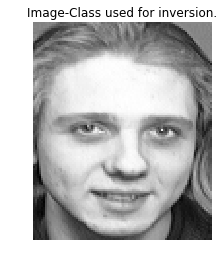

Predictions: [[2.3785289e-03 2.7581907e-03 1.5769165e-04 2.5390834e-04 2.3742126e-05
  1.9623912e-03 1.1549033e-03 6.1063399e-04 3.7899237e-02 3.3462790e-04
  3.0886147e-02 1.8891698e-04 1.3535045e-03 1.8433353e-02 3.4210123e-03
  6.8268512e-04 1.1356210e-03 3.1720495e-03 1.4558429e-02 4.1730767e-03
  4.0925632e-04 3.7020242e-03 7.0566696e-04 1.7656954e-02 5.3017851e-02
  3.7319083e-03 1.2653002e-05 4.6640050e-02 7.0202923e-01 1.4712469e-02
  7.4628312e-03 1.7786603e-02 6.4313528e-04 2.8439490e-03 5.5993308e-04
  1.8584960e-04 3.3009361e-05 1.0162874e-03 2.1943319e-04 1.0921680e-03]]
 Acc: 0.842710 and Loss: 0.157714 and Best Loss: 0.077501
Loop Escape.


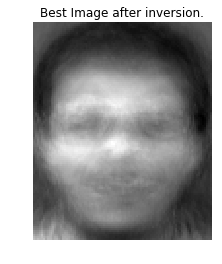

Predictions: [[4.8189409e-04 4.0719419e-04 3.2815065e-03 2.0284796e-02 1.9764761e-03
  1.3295734e-02 5.5240714e-03 4.1232505e-03 1.0674723e-03 5.4615964e-03
  7.8762270e-05 1.9068981e-03 6.2152829e-02 2.7510393e-04 1.8633395e-05
  9.2507387e-04 8.8522973e-04 5.5507580e-03 5.3224934e-04 2.7639617e-04
  5.2083959e-04 2.0402240e-02 2.0178048e-04 6.0804690e-05 6.3641266e-05
  5.4780749e-04 3.8100461e-05 2.4052302e-03 4.5994020e-01 8.9648794e-03
  3.1435848e-06 3.7774881e-03 2.9430483e-04 1.0175745e-03 6.6498404e-05
  1.1185332e-05 5.8037681e-03 2.7363156e-03 3.1894294e-04 3.6431938e-01]]


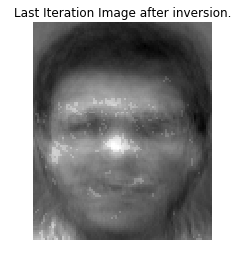

Predictions: [[8.7987850e-05 4.0547622e-04 2.7600846e-03 1.2201804e-02 1.0521412e-02
  3.1783471e-03 3.5862052e-03 1.3592391e-04 4.2488417e-04 6.4620003e-03
  6.7983761e-05 5.1091262e-03 2.8177241e-02 1.6445336e-03 1.3220363e-04
  6.2509286e-03 1.2175696e-04 6.6394331e-03 6.8103685e-04 1.0307002e-03
  2.8322034e-03 4.7181090e-03 1.2411460e-03 3.3599950e-05 9.7561750e-04
  3.1575209e-03 1.1365253e-04 8.0470834e-03 8.4270972e-01 2.9421060e-03
  3.0414863e-05 1.5895715e-03 1.5729796e-03 1.3733583e-03 1.6307400e-04
  1.6389861e-04 9.5736161e-03 1.9261185e-03 3.7006701e-03 2.3516420e-02]]


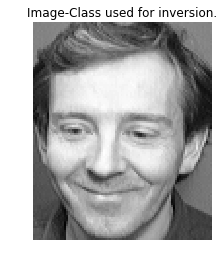

Predictions: [[3.0823948e-04 4.8118738e-05 1.0341758e-04 1.4152139e-04 5.4610937e-06
  2.3043773e-04 1.3143112e-04 9.3115332e-06 1.4902034e-04 6.6027142e-06
  2.6122128e-04 1.8145825e-05 5.0685401e-03 2.3920848e-05 2.1532778e-05
  1.7383191e-04 5.7090528e-04 7.8065659e-06 3.2108830e-04 2.1351411e-03
  2.1585702e-05 1.4873759e-03 1.1209066e-03 2.6257723e-04 2.9053399e-04
  5.6862071e-05 4.8828670e-06 2.1331709e-04 1.2283396e-03 9.8228157e-01
  4.3196749e-05 1.8252147e-03 2.3133676e-04 2.3269666e-04 3.3463562e-05
  3.7945989e-05 2.3367191e-05 2.3509611e-04 9.9486067e-07 6.3297746e-04]]
 Acc: 0.790318 and Loss: 0.209811 and Best Loss: 0.157678
Loop Escape.


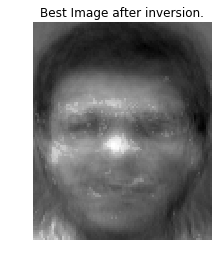

Predictions: [[1.7653903e-04 5.4922560e-04 2.6293956e-03 1.4767717e-02 1.2675011e-02
  3.4001085e-03 1.9589295e-03 4.3773009e-05 3.1309217e-04 2.6168325e-03
  8.8060115e-05 3.7412096e-03 3.0058760e-02 7.4410532e-04 2.5738779e-04
  4.1648853e-03 4.2987222e-04 1.5298287e-02 3.7274361e-04 4.4386604e-04
  1.3469645e-03 1.5455760e-03 1.2421333e-03 9.0359790e-05 8.8534702e-04
  2.6221699e-03 1.2276316e-04 2.3046075e-03 1.9096797e-03 8.4230703e-01
  3.1247826e-05 7.1790296e-04 2.5847994e-03 4.9204851e-04 4.0158298e-04
  2.6470589e-05 1.1504662e-02 1.8010064e-03 2.7164044e-03 3.0617554e-02]]


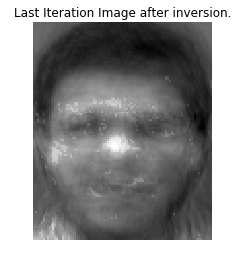

Predictions: [[2.9505973e-04 8.8325480e-04 1.7488855e-03 2.2857059e-02 2.1338150e-02
  2.8307044e-03 2.5394375e-03 2.6585234e-05 3.8593853e-04 2.4669732e-03
  6.4924126e-05 7.5454903e-03 3.8241763e-02 8.9520344e-04 1.0697719e-04
  7.2486731e-03 4.9231382e-04 2.1339417e-02 3.5937800e-04 7.0876151e-04
  1.4990679e-03 2.0285386e-03 2.8944782e-03 1.9670000e-04 8.3328545e-04
  4.8889853e-03 1.3301038e-04 6.1256709e-03 1.2703008e-03 7.9031843e-01
  6.6249166e-05 9.5781405e-04 6.5915817e-03 4.4974824e-04 2.0450757e-04
  4.9872186e-05 1.0460805e-02 2.4438889e-03 3.3188632e-03 3.2893360e-02]]


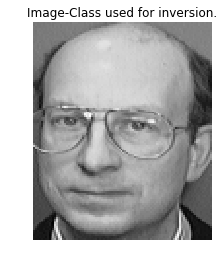

Predictions: [[3.13323643e-03 2.25228854e-04 1.42683912e-05 6.61110278e-07
  4.25982734e-07 1.13174065e-05 2.02056126e-05 4.87214944e-04
  4.44119869e-05 4.20879223e-06 1.77413970e-03 4.99999769e-05
  4.94774167e-06 3.14097182e-04 1.00196758e-03 3.52686649e-04
  1.43380266e-05 8.85750211e-08 7.22317398e-03 2.99576466e-04
  4.28493455e-04 1.48772169e-05 8.78304218e-06 1.03728409e-04
  3.64391773e-04 2.55962277e-05 1.71715510e-05 4.90010367e-04
  8.81788600e-03 1.61126384e-03 9.59951580e-01 5.93943405e-05
  2.71885983e-06 3.33798403e-06 6.09677983e-03 6.89945742e-03
  2.65916719e-06 1.70993062e-05 9.23200932e-05 1.64060202e-05]]
 Acc: 0.678482 and Loss: 0.320855 and Best Loss: 0.272405
Loop Escape.


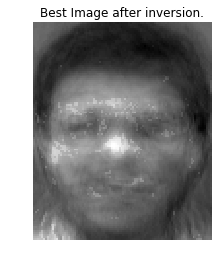

Predictions: [[2.65570096e-04 6.93972572e-04 1.61215710e-03 3.99584994e-02
  1.63626689e-02 1.06769064e-02 5.09521458e-03 1.20601195e-04
  1.84748205e-03 1.17834779e-02 2.67665484e-04 1.34230210e-02
  3.42126414e-02 7.53938337e-04 5.30849735e-04 5.29324589e-03
  7.58293259e-04 1.45911081e-02 1.75978220e-03 5.65939001e-04
  3.15554277e-03 2.31828494e-03 1.91010069e-03 2.31421043e-04
  1.83317042e-03 5.38173737e-03 1.47487590e-04 1.58617608e-02
  2.09589163e-03 5.76185808e-03 7.27500439e-01 2.71056034e-03
  2.31948029e-03 6.69340196e-04 2.78882828e-04 8.49004064e-05
  1.75732989e-02 9.70746391e-04 4.16309107e-03 4.44590263e-02]]


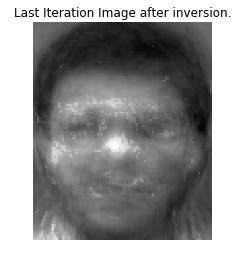

Predictions: [[2.26412347e-04 6.46988163e-04 1.16817106e-03 3.05540487e-02
  1.26708001e-02 1.26024038e-02 6.75514247e-03 1.06890984e-04
  2.42740591e-03 1.95976868e-02 2.76694540e-04 1.29456948e-02
  4.40650061e-02 6.09676994e-04 5.13214036e-04 6.59154588e-03
  1.22121617e-03 3.10770757e-02 1.52734644e-03 3.44302010e-04
  3.08224116e-03 3.86809511e-03 1.62585045e-03 2.25699623e-04
  2.00251630e-03 4.00547963e-03 1.88099526e-04 1.52269471e-02
  2.09537917e-03 5.15234238e-03 6.78481579e-01 1.81577296e-03
  2.18608673e-03 5.85883565e-04 1.99634102e-04 9.83505815e-05
  2.34763399e-02 1.03624386e-03 4.34445404e-03 6.43752515e-02]]


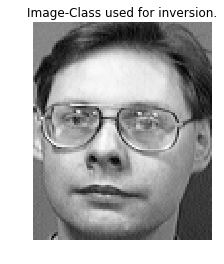

Predictions: [[3.2041434e-04 2.1711430e-03 1.5509046e-03 1.6531067e-05 8.3875500e-05
  1.3748301e-03 1.3761189e-04 1.1045232e-04 1.8140257e-04 4.2123211e-06
  2.9521373e-03 4.3002999e-04 6.5405213e-04 4.1346808e-05 5.5990851e-04
  4.9284962e-04 1.0477081e-04 2.2542890e-04 2.5710146e-04 7.6373885e-03
  1.2499599e-05 4.4037568e-04 3.2440359e-05 7.8626757e-04 1.7574044e-04
  1.8747013e-04 3.1637560e-06 1.9135596e-03 4.6713831e-04 1.6229526e-03
  4.6868423e-05 9.6495104e-01 1.2607232e-04 8.0096638e-03 3.3610835e-05
  5.1520031e-04 1.2246109e-04 1.2243489e-03 1.2814043e-05 9.8885530e-06]]
 Acc: 0.820503 and Loss: 0.179595 and Best Loss: 0.082244
Loop Escape.


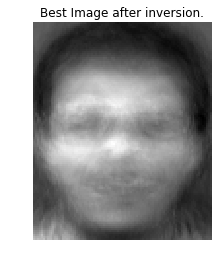

Predictions: [[5.08287514e-04 4.45253565e-04 4.24589915e-03 2.53334474e-02
  2.33271928e-03 1.83708332e-02 6.23982074e-03 4.75547602e-03
  1.21543498e-03 5.62491827e-03 9.79767137e-05 2.17902707e-03
  7.39072114e-02 3.12149350e-04 2.31743707e-05 1.09875319e-03
  9.95956711e-04 6.00039074e-03 6.30804105e-04 3.66730586e-04
  6.24443986e-04 2.02167053e-02 2.02404102e-04 7.74217406e-05
  8.54918544e-05 6.41419552e-04 4.64004661e-05 2.90964916e-03
  6.90949056e-03 9.59851686e-03 3.79131461e-06 3.62537593e-01
  3.40992410e-04 1.20082451e-03 7.10987078e-05 1.40289285e-05
  6.73529599e-03 3.32665257e-03 3.70736379e-04 4.29402769e-01]]


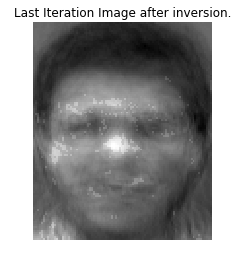

Predictions: [[1.09631335e-04 5.38187393e-04 9.63972241e-04 3.16453092e-02
  1.42621519e-02 2.02680053e-03 1.66972342e-03 1.90798364e-05
  1.51477783e-04 2.04955088e-03 1.45056591e-04 8.65015201e-03
  1.74111258e-02 6.70657493e-04 2.77937914e-04 5.20953769e-03
  5.49128861e-04 1.36207584e-02 9.47387831e-04 1.03319611e-03
  2.71068467e-03 1.38210051e-03 1.06858218e-03 1.85232129e-04
  2.87441711e-04 6.80220453e-03 4.41546610e-04 6.03110716e-03
  1.43541628e-03 3.02259787e-03 2.99654548e-05 8.20502877e-01
  5.53872716e-03 7.90137274e-04 2.65132956e-04 5.38080385e-05
  1.26613081e-02 1.68335543e-03 9.13017988e-03 2.40267757e-02]]


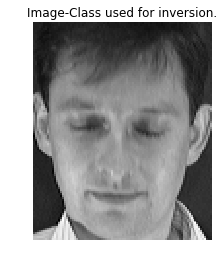

Predictions: [[1.1001412e-06 7.6516491e-04 8.1511843e-04 3.3643378e-03 2.8621037e-02
  2.6749727e-05 2.7391850e-04 2.7618377e-04 1.8295696e-03 2.3307153e-05
  9.0539776e-05 1.0420324e-05 4.1374758e-05 1.6205820e-03 4.0069312e-06
  5.2414043e-07 5.2279781e-04 1.5922272e-01 1.3792467e-06 4.3574317e-05
  1.0747969e-03 1.3465041e-03 8.5964933e-04 2.3299954e-03 3.2949451e-05
  1.5852960e-04 1.2250475e-03 2.4671093e-04 5.9579565e-06 3.5161568e-06
  2.4400110e-06 1.3089080e-04 7.9032588e-01 2.4500834e-03 1.4404175e-07
  1.3263057e-03 4.6325981e-04 6.1934428e-05 1.3018209e-04 2.7072724e-04]]
 Acc: 0.675760 and Loss: 0.324764 and Best Loss: 0.185128
Loop Escape.


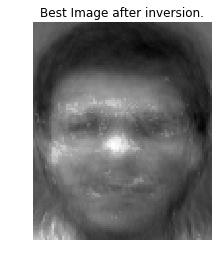

Predictions: [[1.6664629e-04 4.6230640e-04 2.9503852e-03 1.8361060e-02 2.0957999e-02
  4.7769379e-03 2.2164278e-03 9.4902134e-05 1.7020006e-04 3.8326054e-03
  1.7686060e-04 4.2839451e-03 2.1942977e-02 6.4285717e-04 3.0264052e-04
  2.6402944e-03 5.7819777e-04 1.6863545e-02 6.1390555e-04 7.4943330e-04
  2.6376138e-03 1.3366815e-03 1.2997781e-03 8.4313411e-05 8.7695918e-04
  2.8824164e-03 1.8915672e-04 3.0826733e-03 1.7266053e-03 8.0216648e-03
  3.2930624e-05 1.3427440e-03 8.1209338e-01 4.5682708e-04 3.2886502e-04
  2.6471784e-05 1.8527394e-02 1.3040585e-03 4.2258282e-03 3.6739610e-02]]


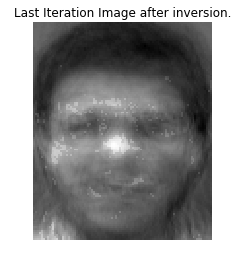

Predictions: [[1.2878550e-04 9.2584320e-04 3.9867652e-03 3.0797560e-02 1.1127200e-02
  8.2950788e-03 3.7499724e-03 5.6462657e-05 1.0862651e-04 2.1182243e-03
  3.5379070e-04 7.6575093e-03 5.6434400e-02 8.9401338e-04 2.8957927e-04
  5.9081381e-03 1.4334249e-03 3.5851676e-02 1.8552569e-03 1.9088881e-03
  5.9136422e-03 6.2149251e-03 1.3987371e-03 8.2894272e-05 1.3996037e-03
  1.1514649e-02 3.8649049e-04 1.3698802e-02 1.9653437e-03 1.9389149e-02
  4.4748227e-05 4.8432061e-03 6.7575997e-01 3.8476696e-04 5.9180037e-04
  6.8220339e-05 3.8690936e-02 1.3532739e-03 5.9278551e-03 3.6489818e-02]]


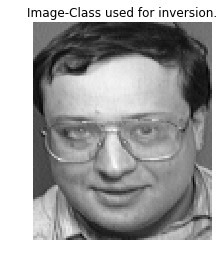

Predictions: [[1.27658466e-04 9.39934107e-04 3.09197605e-03 1.01847232e-04
  1.09143031e-03 4.71242092e-05 8.08761433e-06 4.60083265e-06
  3.22923843e-05 1.45219456e-05 2.59844965e-04 1.55675934e-05
  9.10090574e-04 1.77970196e-05 1.54578665e-05 3.08596937e-05
  2.14790489e-04 2.07021227e-03 3.92096466e-04 4.82280226e-03
  1.13442693e-05 7.94049527e-04 4.47887322e-03 7.19353731e-04
  1.52808812e-03 3.38714949e-06 3.99325509e-05 2.36676478e-05
  1.64955316e-04 9.46923101e-04 3.89868910e-06 1.19202603e-02
  2.69559765e-04 9.14638221e-01 1.26340055e-05 6.64828849e-06
  8.42928793e-03 4.11508679e-02 1.12151152e-04 5.36841806e-04]]
 Acc: 0.794717 and Loss: 0.205998 and Best Loss: 0.200276
Loop Escape.


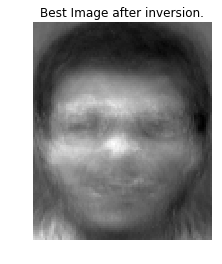

Predictions: [[5.92090946e-04 5.98112994e-04 4.52077016e-03 1.50350193e-02
  1.12985680e-02 8.74088705e-03 3.93051375e-03 6.59660262e-04
  2.57794105e-04 3.95305408e-03 2.12044106e-04 2.37732730e-03
  4.06059138e-02 4.01628349e-04 9.69568791e-05 1.68402027e-03
  8.75103346e-04 2.09350809e-02 1.25755265e-03 4.70610918e-04
  2.82656192e-03 4.73836577e-03 8.65621900e-04 1.08646847e-04
  6.65439467e-04 1.39943312e-03 2.39958346e-04 9.35448217e-04
  3.49907507e-03 1.29915876e-02 9.76012325e-06 1.76049792e-03
  1.17435877e-03 7.11886406e-01 2.63790251e-04 3.34332544e-05
  1.49243688e-02 1.10346684e-03 8.43058340e-04 1.21228136e-01]]


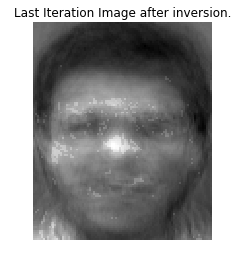

Predictions: [[3.1025888e-04 4.0901639e-04 1.3238628e-03 2.7309759e-02 2.0131368e-02
  3.3421584e-03 2.8528674e-03 2.4606143e-05 1.3757516e-04 3.5924891e-03
  3.0534538e-05 1.0007494e-02 2.6217798e-02 8.2803314e-04 4.4811246e-04
  3.2305541e-03 4.4397736e-04 1.2514767e-02 1.8476762e-03 8.3236519e-04
  2.8345089e-03 1.8387281e-03 1.2370576e-03 1.4069442e-04 1.1586570e-03
  1.1141739e-03 3.5084126e-04 5.0528077e-03 4.0303981e-03 4.6966509e-03
  5.9782808e-05 2.4154808e-03 1.9014935e-03 7.9471743e-01 2.2746451e-04
  6.0977796e-05 2.2737201e-02 1.8243330e-03 2.3263560e-03 3.5439618e-02]]


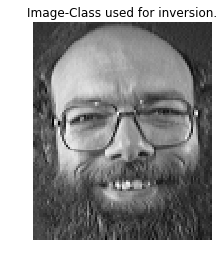

Predictions: [[5.22134324e-05 7.30125059e-04 2.34553772e-06 2.63652367e-07
  1.21385619e-06 4.68170794e-04 5.72983372e-05 9.51937051e-04
  3.33344433e-05 1.07811466e-04 2.26793904e-03 5.53299971e-02
  2.21442087e-06 3.88153130e-03 4.24806291e-04 2.80544627e-02
  1.61804910e-05 2.03672312e-06 9.83353555e-02 2.76577019e-04
  1.82573131e-04 1.65647449e-04 2.61431796e-05 4.01807833e-04
  2.57686042e-04 3.48049891e-03 1.71104773e-06 1.35405967e-03
  6.04790868e-04 1.19016133e-03 1.41695244e-02 1.58115567e-04
  1.60976313e-04 8.35455940e-05 7.84651220e-01 1.36201887e-03
  1.17542768e-04 2.31140439e-05 5.97304956e-04 1.57072318e-05]]
 Acc: 0.753167 and Loss: 0.247988 and Best Loss: 0.205159
Loop Escape.


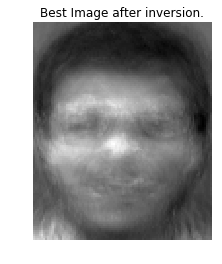

Predictions: [[8.31719255e-04 7.98206020e-04 5.91059355e-03 2.35408712e-02
  1.82473715e-02 1.15839969e-02 6.60297181e-03 1.16754789e-03
  3.73805116e-04 6.27423450e-03 3.08596645e-04 3.45134432e-03
  5.36388978e-02 5.85880247e-04 1.35959461e-04 2.36499845e-03
  1.34716346e-03 2.37706657e-02 1.53935072e-03 7.83420459e-04
  4.25007707e-03 6.77260431e-03 1.24566769e-03 1.87660378e-04
  1.20795355e-03 1.95064384e-03 3.01493157e-04 1.45654497e-03
  4.78603784e-03 2.46560797e-02 1.51674813e-05 3.22517613e-03
  2.19147652e-03 3.70799960e-03 6.36404514e-01 4.08421365e-05
  2.19385307e-02 1.59796735e-03 1.36234821e-03 1.19443685e-01]]


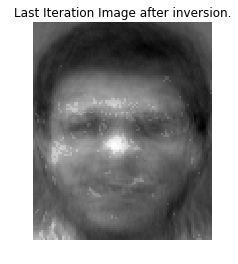

Predictions: [[2.5226877e-04 8.5369259e-04 4.3233074e-03 2.5694491e-02 2.0652710e-02
  4.6926551e-03 4.1978150e-03 4.2933178e-05 3.9870545e-04 4.4083162e-03
  4.7701711e-04 7.1875546e-03 3.8608737e-02 1.4923314e-03 4.0153490e-04
  1.1699343e-02 1.2604235e-03 1.9709058e-02 8.0359844e-04 6.6389376e-04
  3.6440096e-03 3.2635280e-03 1.2523506e-02 1.3085808e-04 1.4091290e-03
  7.2732437e-03 5.7739415e-04 2.6666755e-03 4.5884112e-03 1.1353513e-02
  1.8950152e-05 2.8911699e-03 2.8228429e-03 8.6187135e-04 7.5316745e-01
  6.6793204e-05 3.0744640e-02 2.2336522e-03 2.4408326e-03 9.5011638e-03]]


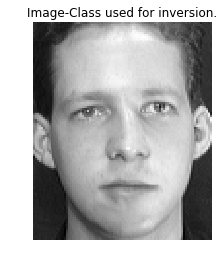

Predictions: [[6.16858772e-04 2.71734871e-06 5.76920820e-06 2.15913602e-07
  2.98095324e-06 1.87097303e-05 9.59206545e-07 3.96804884e-04
  9.42411061e-05 5.90132608e-04 8.87455768e-04 2.14459747e-03
  1.26063128e-07 5.22259157e-03 1.34653936e-03 3.90767382e-04
  1.06596699e-05 5.39331637e-08 9.59659519e-05 4.78316088e-06
  7.94528797e-02 7.52258999e-03 1.05445879e-05 1.17795316e-04
  7.81447852e-07 8.27256081e-05 1.12924590e-05 1.59200383e-04
  5.97560254e-04 8.09868288e-06 4.58466075e-03 4.70810919e-05
  8.15850589e-03 1.02970660e-06 1.21044104e-04 8.87275994e-01
  7.64152674e-07 3.84526220e-06 1.06142543e-05 2.03286348e-07]]
 Acc: 0.906303 and Loss: 0.093887 and Best Loss: 0.093887
Loop Escape.


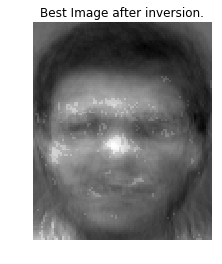

Predictions: [[1.88194957e-04 1.92714666e-04 1.46202859e-03 8.64846539e-03
  2.81356066e-03 4.94190771e-03 6.77707663e-04 3.83061342e-05
  3.52569390e-04 3.02514550e-03 6.06194844e-05 2.73447065e-03
  1.84538662e-02 4.21465171e-04 4.20162869e-05 2.69883079e-03
  8.20306363e-04 5.65760443e-03 3.00518208e-04 3.83014791e-04
  2.73232255e-03 1.17717579e-03 3.01467208e-03 1.04496241e-04
  2.02310598e-03 2.49896152e-03 1.69179883e-04 2.10644491e-03
  2.50438205e-03 1.58494036e-03 2.82863348e-05 4.10718191e-03
  1.75633433e-03 3.70325259e-04 1.18720236e-04 9.06302989e-01
  4.61977813e-03 1.59762404e-03 2.20748992e-03 7.06237461e-03]]


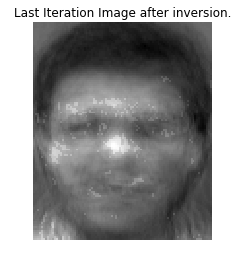

Predictions: [[1.88194957e-04 1.92714666e-04 1.46202859e-03 8.64846539e-03
  2.81356066e-03 4.94190771e-03 6.77707663e-04 3.83061342e-05
  3.52569390e-04 3.02514550e-03 6.06194844e-05 2.73447065e-03
  1.84538662e-02 4.21465171e-04 4.20162869e-05 2.69883079e-03
  8.20306363e-04 5.65760443e-03 3.00518208e-04 3.83014791e-04
  2.73232255e-03 1.17717579e-03 3.01467208e-03 1.04496241e-04
  2.02310598e-03 2.49896152e-03 1.69179883e-04 2.10644491e-03
  2.50438205e-03 1.58494036e-03 2.82863348e-05 4.10718191e-03
  1.75633433e-03 3.70325259e-04 1.18720236e-04 9.06302989e-01
  4.61977813e-03 1.59762404e-03 2.20748992e-03 7.06237461e-03]]


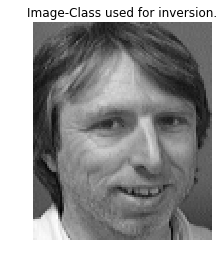

Predictions: [[2.9594946e-04 3.6966121e-03 4.6398551e-03 4.8786629e-04 3.5899046e-03
  1.6722803e-04 2.1127249e-04 1.7943581e-06 3.7780112e-05 6.7862122e-05
  5.2281469e-03 5.5004399e-05 3.3714899e-03 1.2913738e-05 4.1920372e-04
  6.9360613e-05 1.0481933e-03 1.2324343e-03 2.4393314e-04 2.7750370e-03
  1.4349858e-04 1.2697371e-04 8.5708080e-03 1.4376492e-02 5.3585361e-04
  5.4909742e-05 3.0099321e-04 3.4185006e-05 8.3761464e-05 4.0635464e-04
  3.0516412e-05 2.6183936e-04 6.0301065e-04 1.8147428e-03 2.1553585e-04
  2.0845911e-04 9.4235301e-01 1.2365184e-03 3.7066112e-04 6.1995554e-04]]
 Acc: 0.834387 and Loss: 0.165828 and Best Loss: 0.114050
Loop Escape.


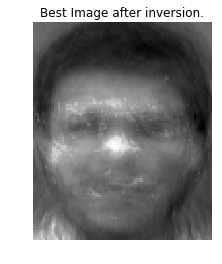

Predictions: [[1.4327650e-04 2.8260952e-04 2.0353126e-03 1.0313691e-02 1.1427293e-02
  2.8905068e-03 1.9934636e-03 7.3877025e-05 1.6932534e-04 3.1940560e-03
  5.4845270e-05 3.9058088e-03 1.5594060e-02 4.9469207e-04 2.3004363e-04
  2.3626371e-03 4.5796129e-04 1.2355797e-02 3.0955370e-04 4.0473338e-04
  1.4656795e-03 1.0506830e-03 7.8494492e-04 6.5675449e-05 5.8440643e-04
  2.5365374e-03 1.2382626e-04 2.2974557e-03 1.9673645e-03 3.6543941e-03
  2.5403948e-05 8.6434238e-04 2.3136351e-03 5.6765322e-04 2.7189907e-04
  2.5392299e-05 8.8508743e-01 8.6690317e-04 2.1461861e-03 2.4606679e-02]]


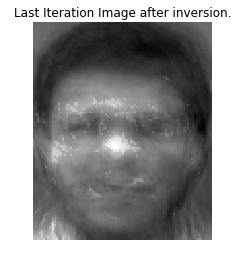

Predictions: [[1.4464541e-04 4.5433021e-04 1.3436278e-03 1.5853498e-02 1.8896503e-02
  2.6757454e-03 1.8904898e-03 4.2564625e-05 1.4156838e-04 2.4671759e-03
  5.5816054e-05 8.9301178e-03 1.6043689e-02 6.2026596e-04 1.2632512e-04
  4.7140862e-03 4.7037393e-04 1.7736789e-02 5.9314718e-04 4.4982336e-04
  3.2500373e-03 2.5500359e-03 1.2692445e-03 6.2224804e-05 3.5035706e-04
  3.3911571e-03 1.4738033e-04 3.9660637e-03 3.2756026e-03 5.1045367e-03
  3.0152802e-05 2.1734806e-03 3.6482341e-03 1.3683285e-03 2.6673439e-04
  5.8771569e-05 8.3438659e-01 8.4850349e-04 3.6234660e-03 3.6578417e-02]]


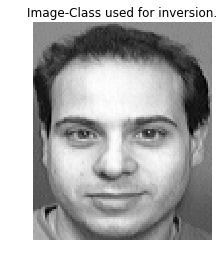

Predictions: [[4.3811355e-02 3.4217946e-03 9.1963471e-04 4.3380731e-03 3.7153750e-03
  3.0672504e-03 2.1480608e-03 2.0975758e-05 8.9187818e-03 4.2326743e-04
  4.4250912e-03 2.0395867e-04 1.5395463e-01 1.3448377e-04 4.1440947e-04
  1.7071331e-04 2.9483089e-02 3.7958659e-02 8.3171176e-03 3.5041038e-02
  6.1598992e-05 1.1227931e-02 1.8044673e-02 4.5688651e-03 7.0255171e-03
  4.5940928e-05 3.1538052e-03 5.5576942e-04 6.6975709e-03 3.8178176e-02
  1.5673086e-04 2.5006669e-02 8.6935511e-04 1.6327314e-02 1.7704644e-05
  2.5839047e-04 1.8490726e-02 4.8108047e-01 1.4688175e-04 2.7198089e-02]]
 Acc: 0.879136 and Loss: 0.120887 and Best Loss: 0.039342
Loop Escape.


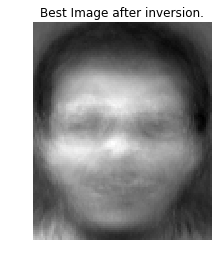

Predictions: [[6.7462050e-04 5.3576002e-04 4.4134264e-03 3.2001972e-02 2.9577054e-03
  2.1509876e-02 7.1561495e-03 5.4464689e-03 1.4397409e-03 7.0663425e-03
  1.3293875e-04 2.5578861e-03 7.8331538e-02 4.0112453e-04 2.9711397e-05
  1.4778805e-03 1.2281319e-03 7.5996933e-03 7.5660553e-04 4.3441736e-04
  6.7972910e-04 2.7233152e-02 2.7269300e-04 9.4173876e-05 1.0700128e-04
  6.9170230e-04 5.2394564e-05 3.7575960e-03 7.8211352e-03 1.2980351e-02
  4.6781583e-06 5.6578419e-03 4.6884449e-04 1.4345634e-03 8.9632988e-05
  1.8646508e-05 8.9184279e-03 2.6547605e-01 4.7041249e-04 4.8761904e-01]]


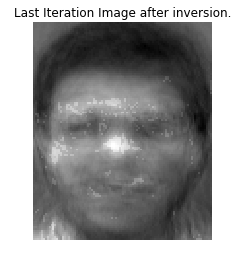

Predictions: [[9.3955983e-05 7.6724583e-04 8.1601890e-04 2.1121839e-02 1.5260230e-02
  4.4093751e-03 1.6722364e-03 2.2466214e-05 1.6662476e-04 2.5525545e-03
  3.7365269e-05 7.2315363e-03 7.6758540e-03 2.1818852e-04 2.8532342e-04
  3.4593563e-03 3.2724786e-04 1.0299826e-02 4.6303729e-04 4.3544397e-04
  2.9223359e-03 2.4356863e-03 1.2339362e-03 3.9406354e-05 1.8235081e-03
  9.3656959e-04 9.6049705e-05 2.7302259e-03 1.3876832e-03 7.0512537e-03
  1.9450306e-05 1.5842227e-03 1.1188898e-03 2.7231465e-04 1.8596473e-04
  3.1092175e-05 4.5187087e-03 8.7913597e-01 7.5845979e-03 7.5765192e-03]]


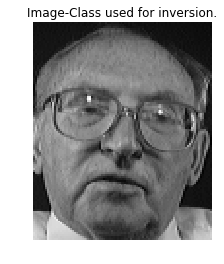

Predictions: [[3.53833798e-07 2.58113556e-02 5.68163705e-05 2.41697285e-06
  2.52991822e-03 2.63925642e-04 6.70940790e-05 1.22088671e-03
  7.44899808e-06 1.89488801e-05 2.14719796e-03 2.14431644e-03
  9.45060219e-06 7.48933351e-04 1.52388684e-05 5.77017141e-04
  2.16213411e-05 1.70969754e-03 9.16473073e-06 4.22204286e-03
  5.57303603e-04 3.81210339e-05 8.67054951e-06 2.08455790e-03
  9.61639762e-06 4.08522901e-05 1.68099416e-06 7.47447775e-04
  7.50168874e-06 1.46023626e-06 2.24355608e-05 1.76369416e-04
  2.17497814e-04 8.25272035e-03 1.21182944e-04 4.32464178e-04
  4.21807133e-02 4.26220140e-05 9.03443873e-01 2.90844873e-05]]
 Acc: 0.831298 and Loss: 0.168253 and Best Loss: 0.126703
Loop Escape.


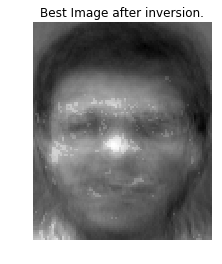

Predictions: [[6.32308584e-05 3.60942504e-04 1.29508285e-03 7.09534204e-03
  7.80557981e-03 2.96373200e-03 8.55292019e-04 4.62610806e-05
  1.08489890e-04 3.35518876e-03 2.12362556e-05 5.20185893e-03
  1.34721715e-02 7.60712137e-04 3.57627316e-04 2.91031087e-03
  3.72768525e-04 2.95542423e-02 3.97882977e-04 3.58753052e-04
  4.49973065e-03 1.69671467e-03 7.53714703e-04 6.29591304e-05
  3.17098689e-04 1.67082134e-03 1.65935635e-04 2.62285420e-03
  1.32681685e-03 1.37911807e-03 1.29770315e-05 1.08384155e-03
  1.69218669e-03 2.61407666e-04 1.01321399e-04 1.94359418e-05
  5.17540798e-03 1.26551301e-03 8.72915566e-01 2.56197732e-02]]


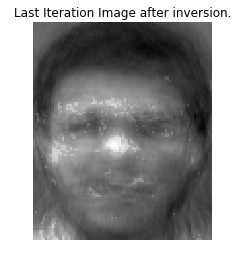

Predictions: [[7.61728297e-05 3.32571071e-04 1.59799377e-03 5.23259677e-03
  1.23298522e-02 3.10730445e-03 9.83504462e-04 7.44615973e-05
  1.12049260e-04 5.05287992e-03 2.20667553e-05 5.91126969e-03
  1.36805074e-02 1.02692493e-03 6.19132828e-04 3.62471747e-03
  2.99282867e-04 3.64498422e-02 4.22748330e-04 6.33001095e-04
  4.44465177e-03 2.35698372e-03 8.96133017e-04 6.48417845e-05
  4.46869904e-04 2.48600589e-03 2.21450013e-04 3.62704648e-03
  2.23043142e-03 1.50822639e-03 1.41339187e-05 8.83291708e-04
  2.02988205e-03 2.97621213e-04 1.02225276e-04 2.21684859e-05
  6.27982570e-03 1.81239343e-03 8.31298172e-01 4.73888032e-02]]


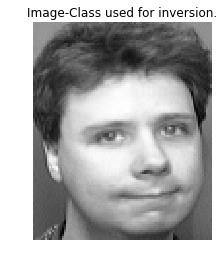

Predictions: [[9.13598633e-04 6.45282198e-05 1.96861918e-03 1.91219000e-03
  4.72601125e-04 1.50110545e-05 1.85888621e-05 4.99730390e-07
  1.92836305e-04 5.44311572e-03 4.02070036e-05 6.88438888e-08
  4.36794740e-04 1.35351938e-05 3.26293521e-05 4.66250167e-05
  4.85254172e-03 1.31902297e-03 3.25668989e-05 8.49981734e-05
  1.14012386e-04 1.09095275e-02 6.59403950e-03 5.00817958e-04
  1.39252486e-04 8.40017456e-05 1.18019257e-03 3.35054347e-06
  5.98676206e-06 5.35122352e-04 1.75424623e-06 1.44908394e-04
  1.37853203e-04 5.50189987e-04 2.73030963e-07 2.66957227e-06
  8.47929732e-06 2.94465129e-03 4.54864175e-06 9.58277702e-01]]

 Above Probability Criteria!: 0.992915034294

Loop Escape.


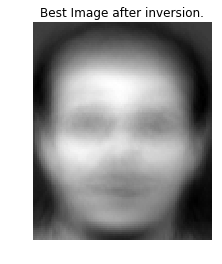

Predictions: [[3.70391645e-05 1.53948167e-05 2.38575522e-04 4.30451153e-04
  1.28799875e-05 7.71911698e-04 2.68319272e-04 4.24837432e-04
  1.32729532e-04 1.78587361e-04 3.24505663e-06 9.29025991e-05
  1.25512679e-03 1.27677922e-05 1.67162000e-06 1.53271376e-05
  4.26135666e-05 5.58499196e-05 1.66838308e-05 9.56301847e-06
  6.63011269e-06 1.63118273e-03 1.87461603e-06 4.63666720e-06
  3.52144269e-07 1.55898997e-05 8.32314527e-07 5.18731482e-04
  1.98226218e-04 9.02146494e-05 2.53459632e-07 1.96960653e-04
  7.44517183e-06 1.08368658e-05 8.61581498e-07 1.12474868e-06
  7.50237377e-05 2.99246720e-04 8.46101921e-06 9.92915034e-01]]


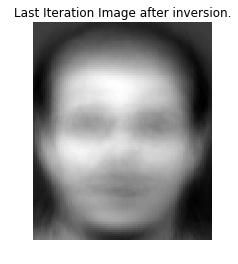

Predictions: [[3.70391645e-05 1.53948167e-05 2.38575522e-04 4.30451153e-04
  1.28799875e-05 7.71911698e-04 2.68319272e-04 4.24837432e-04
  1.32729532e-04 1.78587361e-04 3.24505663e-06 9.29025991e-05
  1.25512679e-03 1.27677922e-05 1.67162000e-06 1.53271376e-05
  4.26135666e-05 5.58499196e-05 1.66838308e-05 9.56301847e-06
  6.63011269e-06 1.63118273e-03 1.87461603e-06 4.63666720e-06
  3.52144269e-07 1.55898997e-05 8.32314527e-07 5.18731482e-04
  1.98226218e-04 9.02146494e-05 2.53459632e-07 1.96960653e-04
  7.44517183e-06 1.08368658e-05 8.61581498e-07 1.12474868e-06
  7.50237377e-05 2.99246720e-04 8.46101921e-06 9.92915034e-01]]


In [7]:
perform_inversion(zca, test_x[0::3])

In [8]:
"""
train_x, test_x, train_y, test_y  = unpack_facedataset() # 7:3 ratio for train:test 
zca = ZCA()
zca.fit(train_x[:2])
img = train_x[10]
img = normalize(img)
face_imshow(img,zca,img.shape)
"""

"""
from sys import stdout
from time import sleep
import numpy as np

a = np.array([10.2,.2,24.5,3,4,5,6,7,8,9,10,11])
for i in range(1,10):
    stdout.write("\r Hye there %d hi deer %d " % (a,i))
    stdout.flush()
    sleep(.25)
stdout.write("\n") # move the cursor to the next line

"""

'\nfrom sys import stdout\nfrom time import sleep\nimport numpy as np\n\na = np.array([10.2,.2,24.5,3,4,5,6,7,8,9,10,11])\nfor i in range(1,10):\n    stdout.write("\r Hye there %d hi deer %d " % (a,i))\n    stdout.flush()\n    sleep(.25)\nstdout.write("\n") # move the cursor to the next line\n\n'